# PROJECT EDA

**Pocess to explore the data and identify patterns in the data**

In [66]:
# Import necessary libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score


pd.set_option("display.max_columns", 100)


In [67]:
# Load the main dataset 
df = pd.read_csv('cleaned_dataset.csv')

# Display the first few rows of the dataset 
df.head()

,LoanId,AmountDisbursed,Interest,LoanBalance,BorrowDate,Product,Branch,ClearDate,CustomerId,Gender,LoanLimit,CreditScore,loan_repayment_txn_count,loan_repayment_total_paid,loan_repayment_first_payment,loan_repayment_last_payment,loan_overpayment,MissedInstalments,Industry,BusinessType,YearEstablished
0,951920,6000,1750,7750.0,2025-11-29,5 weeks credit ease,engineer,2026-03-01,1819,female,8000.0,3500,1,500,2025-11-29,2025-11-29,0,5.0,food & hospitality,green grocery (fruit/vegetables),2017
1,951902,4000,1250,5250.0,2025-11-28,5 weeks credit ease,molo,2026-02-01,1818,female,9600.0,2500,1,1550,2025-11-28,2025-11-28,0,4.0,food & hospitality,retail shop,2019
2,949962,4000,1250,5250.0,2025-11-26,5 weeks credit ease,engineer,2025-12-31,1815,female,8000.0,3500,1,1350,2025-11-26,2025-11-26,0,4.0,food & hospitality,green grocery (fruit/vegetables),2014
3,949189,4000,1250,5250.0,2025-11-25,5 weeks credit ease,molo,2025-12-30,1814,female,10000.0,1500,1,1000,2025-11-25,2025-11-25,0,4.0,food & hospitality,green grocery (fruit/vegetables),2018
4,948984,4000,1250,5250.0,2025-11-24,5 weeks credit ease,molo,2025-12-29,1813,female,10000.0,1500,1,1550,2025-11-24,2025-11-24,0,4.0,business & information,bureau & publishing services,2018


In [68]:
# James: Convert date columns to datetime format for easier analysis

# BorrowDate:  MM/DD/YYYY (Keep dayfirst=False)
df["BorrowDate"] = pd.to_datetime(df["BorrowDate"], errors="coerce", dayfirst=False)

# problematic columns: Use format='mixed' to handle the mix of DD/MM/YYYY and YYYY-MM-DD
df["loan_repayment_first_payment"] = pd.to_datetime(df["loan_repayment_first_payment"], errors="coerce", dayfirst=True, format='mixed')
df["loan_repayment_last_payment"] = pd.to_datetime(df["loan_repayment_last_payment"], errors="coerce", dayfirst=True, format='mixed')

# ClearDate:  YYYY-MM-DD
df["ClearDate"] = pd.to_datetime(df["ClearDate"], errors="coerce", format="%Y-%m-%d")

# Check the result
df.head()

,LoanId,AmountDisbursed,Interest,LoanBalance,BorrowDate,Product,Branch,ClearDate,CustomerId,Gender,LoanLimit,CreditScore,loan_repayment_txn_count,loan_repayment_total_paid,loan_repayment_first_payment,loan_repayment_last_payment,loan_overpayment,MissedInstalments,Industry,BusinessType,YearEstablished
0,951920,6000,1750,7750.0,2025-11-29,5 weeks credit ease,engineer,2026-03-01,1819,female,8000.0,3500,1,500,2025-11-29,2025-11-29,0,5.0,food & hospitality,green grocery (fruit/vegetables),2017
1,951902,4000,1250,5250.0,2025-11-28,5 weeks credit ease,molo,2026-02-01,1818,female,9600.0,2500,1,1550,2025-11-28,2025-11-28,0,4.0,food & hospitality,retail shop,2019
2,949962,4000,1250,5250.0,2025-11-26,5 weeks credit ease,engineer,2025-12-31,1815,female,8000.0,3500,1,1350,2025-11-26,2025-11-26,0,4.0,food & hospitality,green grocery (fruit/vegetables),2014
3,949189,4000,1250,5250.0,2025-11-25,5 weeks credit ease,molo,2025-12-30,1814,female,10000.0,1500,1,1000,2025-11-25,2025-11-25,0,4.0,food & hospitality,green grocery (fruit/vegetables),2018
4,948984,4000,1250,5250.0,2025-11-24,5 weeks credit ease,molo,2025-12-29,1813,female,10000.0,1500,1,1550,2025-11-24,2025-11-24,0,4.0,business & information,bureau & publishing services,2018


# Final data cleanup

In [69]:
# James: More data cleaning 
# A customer cannot make a repayment 100 days BEFORE they borrowed the money.
# We allow a small buffer (-10 days) for potential booking errors, but anything less is garbage.

df['days_to_first'] = (df['loan_repayment_first_payment'] - df['BorrowDate']).dt.days
df = df[(df['days_to_first'] >= -10) | (df['days_to_first'].isna())].copy()

# EDA per Hypothesis

**Please mark your code with the first comment having your name. e.g. James - then explain what you are doing in the block**

In [70]:
# More data cleaning 
# A customer cannot make a repayment 100 days BEFORE they borrowed the money.
# We allow a small buffer (-10 days) for potential booking errors, but anything less is garbage.
df['days_to_first'] = (df['loan_repayment_first_payment'] - df['BorrowDate']).dt.days
df = df[(df['days_to_first'] >= -10) | (df['days_to_first'].isna())].copy()

# The data logs the same loan twice. We keep only the first instance.
df = df.drop_duplicates(subset=['CustomerId', 'BorrowDate'], keep='first')

# A loan cannot be cleared BEFORE it was borrowed.
df = df[df['ClearDate'] >= df['BorrowDate']].copy()

# A business established in 2024 cannot borrow money in 2023.
df = df[df['YearEstablished'] <= df['BorrowDate'].dt.year].copy()

# Cleanup to remove Product types (sme - 3 months, sme - 4 months and 12 weeks credit ease) fron the dataset
df = df[~df['Product'].isin(['sme - 3 months', 'sme - 4 months', '12 weeks credit ease'])]
df.info()

df.shape

<class 'pandas.core.frame.DataFrame'>
Index: 1565 entries, 0 to 3469
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   LoanId                        1565 non-null   int64         
 1   AmountDisbursed               1565 non-null   int64         
 2   Interest                      1565 non-null   int64         
 3   LoanBalance                   1565 non-null   float64       
 4   BorrowDate                    1565 non-null   datetime64[ns]
 5   Product                       1565 non-null   object        
 6   Branch                        1565 non-null   object        
 7   ClearDate                     1565 non-null   datetime64[ns]
 8   CustomerId                    1565 non-null   int64         
 9   Gender                        1565 non-null   object        
 10  LoanLimit                     1565 non-null   float64       
 11  CreditScore                   1565 

(1565, 22)

Number of defaulters: 133
Percentage of Defaults vs Non-Defaults:
 0    91.501597
1     8.498403
Name: proportion, dtype: float64


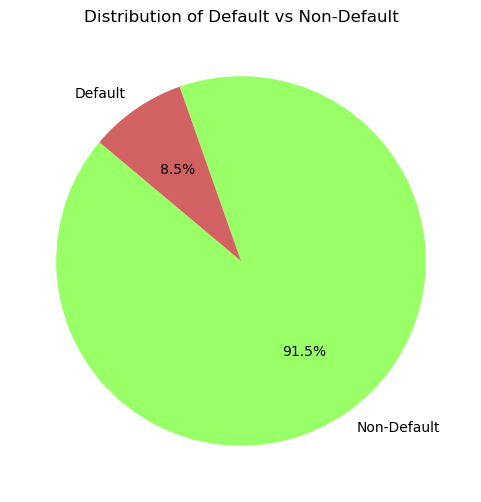

In [71]:
## Additional data cleaning

# James
# Understading the target variable Default where default is when ClearDate is greater than 2025-12-15 and LoanBalance is greater than 0
defaulters = ((df['ClearDate'] < '2025-12-15') & (df['LoanBalance'] > 0)).astype(int)
print("Number of defaulters:", defaulters.sum())

# Calculate the percentage of defaults vs non-defaults
default_counts = defaulters.value_counts(normalize=True) * 100
print("Percentage of Defaults vs Non-Defaults:\n", default_counts)

# Visualize the distribution of the target variable as a pie chart
plt.figure(figsize=(6, 6))
plt.pie(default_counts, labels=['Non-Default', 'Default'], autopct='%1.1f%%', startangle=140, colors=["#99ff66","#d26161"])
plt.title('Distribution of Default vs Non-Default')
plt.show()

# Heatmap

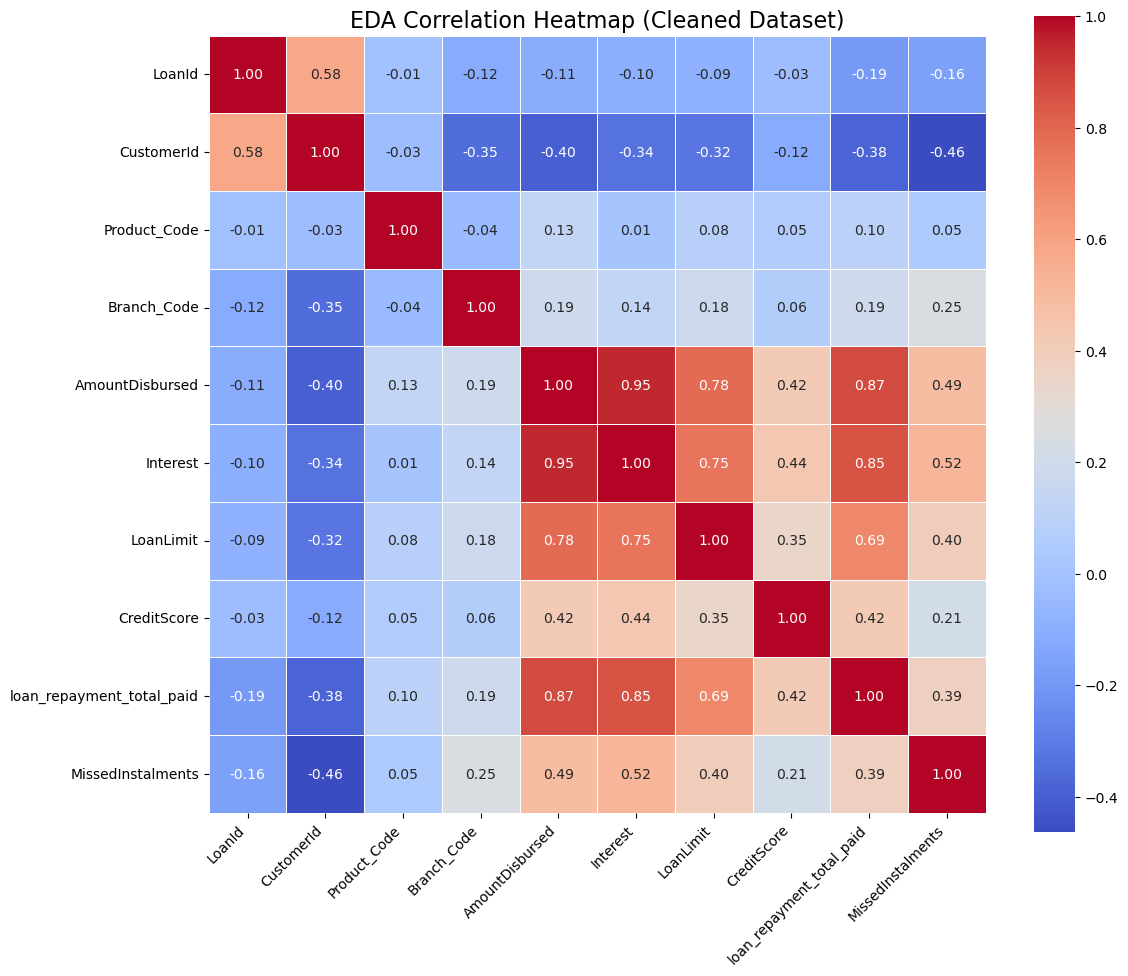

In [72]:
# Convert categorical columns to numerical codes
df['Product_Code'] = df['Product'].astype('category').cat.codes
df['Branch_Code'] = df['Branch'].astype('category').cat.codes

# Columns to include in the heatmap
target_cols = [
    'LoanId', 'CustomerId', 'Product_Code', 'Branch_Code',
    'AmountDisbursed', 'Interest', 'LoanLimit', 'CreditScore',
    'loan_repayment_total_paid', 'MissedInstalments'
]

# Calculate the correlation matrix
corr_matrix = df[target_cols].corr()

# Heatmap visualization
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, square=True)

plt.title('EDA Correlation Heatmap (Cleaned Dataset)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Print and save the heatmap
plt.savefig('correlation_heatmap_cleaned.png')
plt.show()

# Frequency between interest, loan limit, miss installment

Text(0.5, 0, 'Interest')

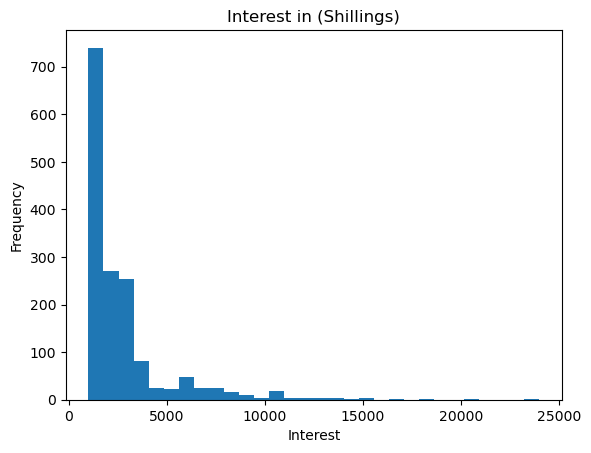

In [73]:
# Nana, Amr

#Plotting Interests in Shillings to check its frequency histogram
ax=df['Interest'].plot(kind='hist'
                      , bins=30, 
                      title= 'Interest in (Shillings)')
ax.set_xlabel ('Interest')

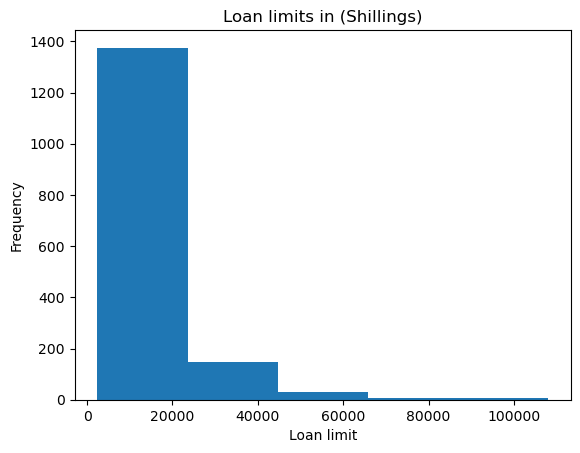

In [74]:
# Nana, Amr
#Plotting (loan limit) to check its frequency histogram.
#The value here are scaled from the csv
ax=df['LoanLimit'].plot(kind='hist'
                      , bins=5, 
                      title= 'Loan limits in (Shillings)')

ax.set_xlabel ('Loan limit')
plt.show()

#I am trying to understand why they are scaled ? and what do the scaled values reflect?

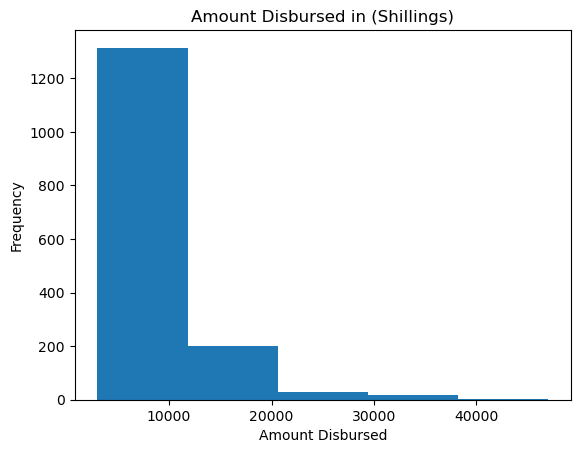

In [75]:
# Nana, Amr
#Plotting (amount disbursed) to check its frequency histogram.

ax=df['AmountDisbursed'].plot(kind='hist'
                      , bins=5, 
                      title= 'Amount Disbursed in (Shillings)')

ax.set_xlabel ('Amount Disbursed')
plt.show()

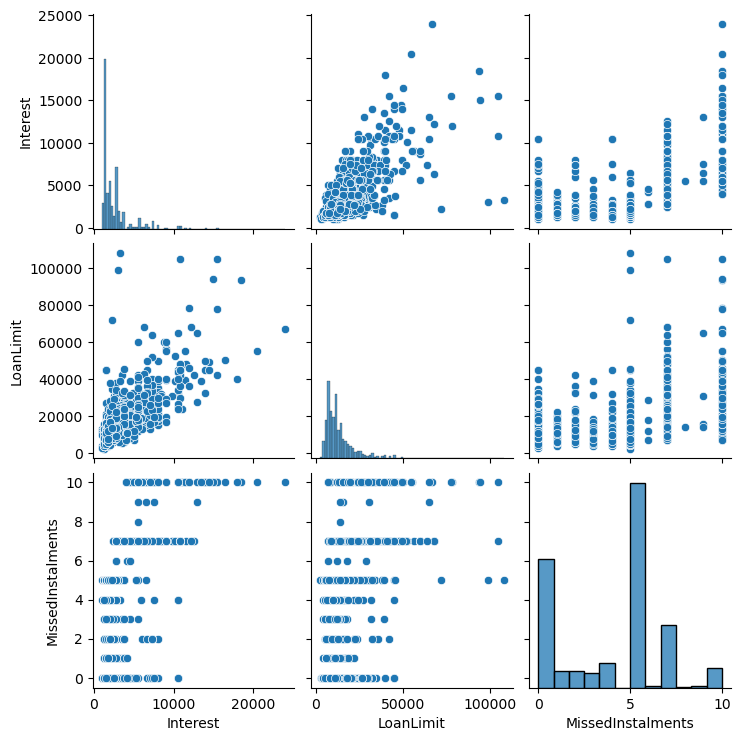

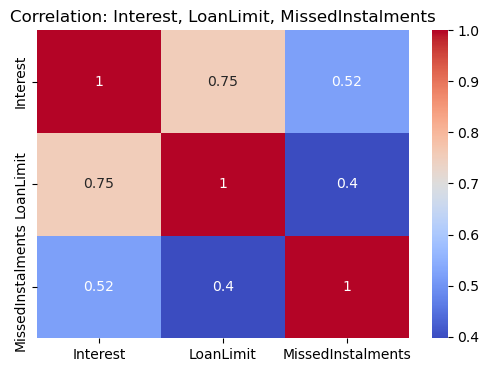

In [76]:
#Kunal
# A pairplot gives you a quick, visual overview of how three variables relate to each other:
# - Scatterplots for each pair
# - Histograms for each individual variable
# - Helps detect linear or non‑linear patterns
# - Helps spot clusters, outliers, or unusual behaviour
# This is the fastest way to visually test whether:
# - Higher Interest -> more MissedInstalments
# - Higher LoanLimit -> more MissedInstalments
# - Interest and LoanLimit are related to each other
# Scatterplot: Interest vs MissedInstalments - If points trend upward -> higher interest leads to more missed instalments.
# Scatterplot: LoanLimit vs MissedInstalments - If points trend upward -> larger loans lead to more missed instalments.
# Scatterplot: Interest vs LoanLimit - Shows whether high‑interest loans are also high‑value loans.
# Histograms: Show the distribution of each variable (e.g., skewed, normal, heavy‑tailed).

sns.pairplot(df[['Interest', 'LoanLimit', 'MissedInstalments']])
plt.show()

plt.figure(figsize=(6,4))
sns.heatmap(df[['Interest','LoanLimit','MissedInstalments']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation: Interest, LoanLimit, MissedInstalments")
plt.show()

# Hypothesis 01. Woman has high risk to make default micro finance due to restricted social power

Conclusion: Company has 131 more male client than female client, while few female clients have higher interest amount than male.
Question: Does it mean female client tend to borrow high amount of loan?

<BarContainer object of 2 artists>

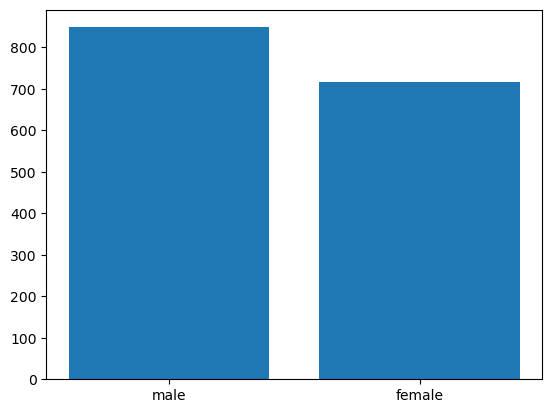

In [77]:
## Nana
gender_counts = df['Gender'].value_counts()
plt.bar(gender_counts.index, gender_counts.values)

Gender
male      848
female    717
Name: count, dtype: int64

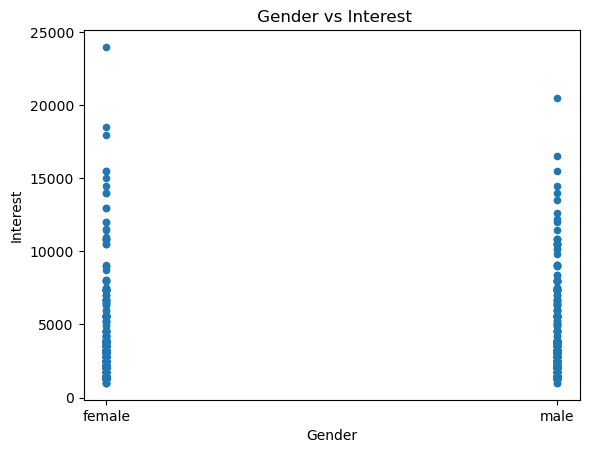

In [78]:
# Amr

#Plotting interest vs Gender to check if the gender affects the amount of interst directly or indirectly.
df.plot (kind='scatter', x= 'Gender' , y = 'Interest' , title = ' Gender vs Interest')
# Most women tend to have interest lower than 10K.
# Most men have interest up to 15K
# Interest higher than 15K is rare for both genders

df['Gender'].value_counts()


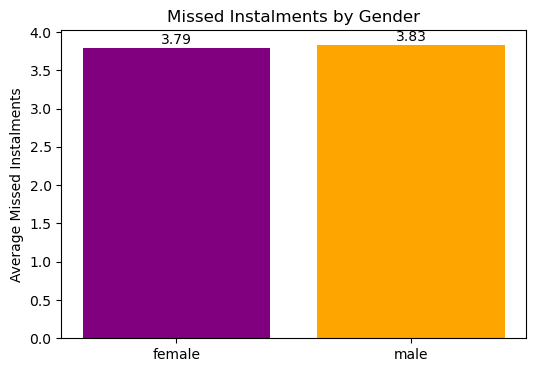

In [79]:
#Kunal

gender_missed = df.groupby('Gender')['MissedInstalments'].mean()

plt.figure(figsize=(6,4))
bars = plt.bar(gender_missed.index, gender_missed.values, color=['purple','orange'])
plt.ylabel("Average Missed Instalments")
plt.title("Missed Instalments by Gender")

# Add numbers on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f"{yval:.2f}", ha='center')

plt.show()

# Hypothesis 02. Customer who has high credit score makes less miss instalments

Conclusion : This suggests that high credit scores do not necessarily correlate with lower missed instalments.
High credit scores are also associated with higher average missed instalments as the amount of loan is higher than lower credit scores.

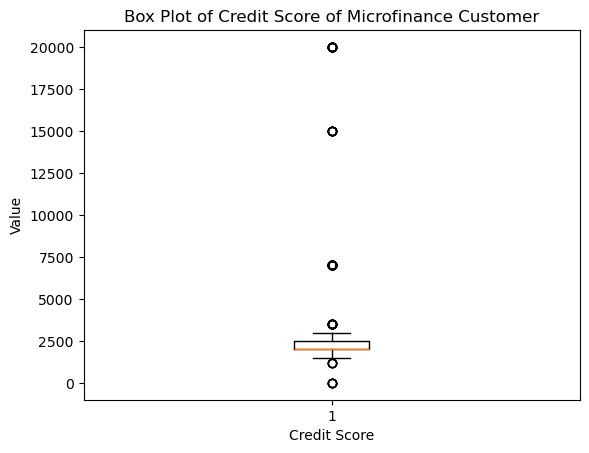

In [80]:
# Nana - Box plot of Credit Score to identify outliers and distribution
plt.boxplot(df['CreditScore'])

plt.xlabel('Credit Score')
plt.ylabel('Value')
plt.title('Box Plot of Credit Score of Microfinance Customer')

plt.show()

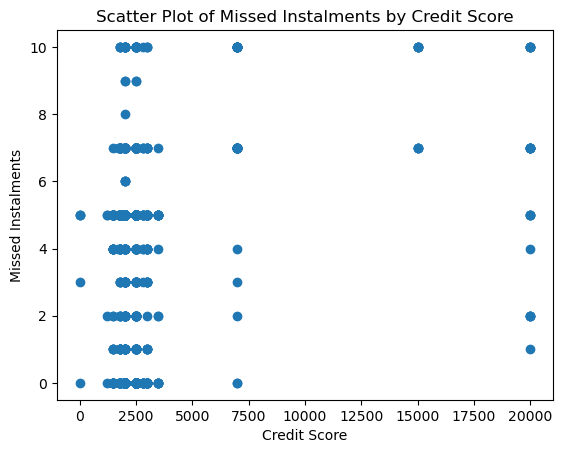

In [81]:
# Nana, Kunal
# Scatter plots 

plt.scatter(df['CreditScore'], df['MissedInstalments'])

plt.xlabel('Credit Score')
plt.ylabel('Missed Instalments')
plt.title('Scatter Plot of Missed Instalments by Credit Score')

plt.show()

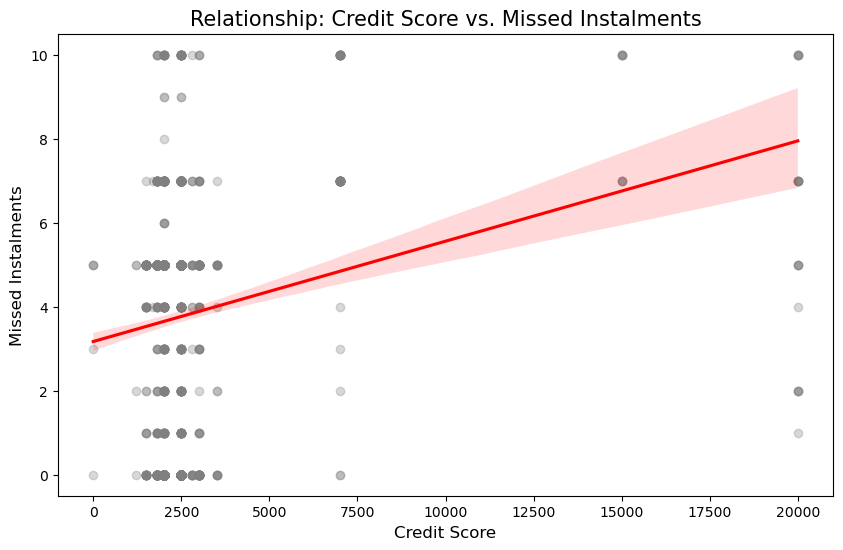

In [82]:
# Sumin
# Visualization: Scatter plot with regression line - Credit Score vs. Missed Instalments
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='CreditScore', y='MissedInstalments', 
            scatter_kws={'alpha':0.3, 'color':'gray'}, line_kws={'color':'red'})

plt.title('Relationship: Credit Score vs. Missed Instalments', fontsize=15)
plt.xlabel('Credit Score', fontsize=12)
plt.ylabel('Missed Instalments', fontsize=12)
plt.show()

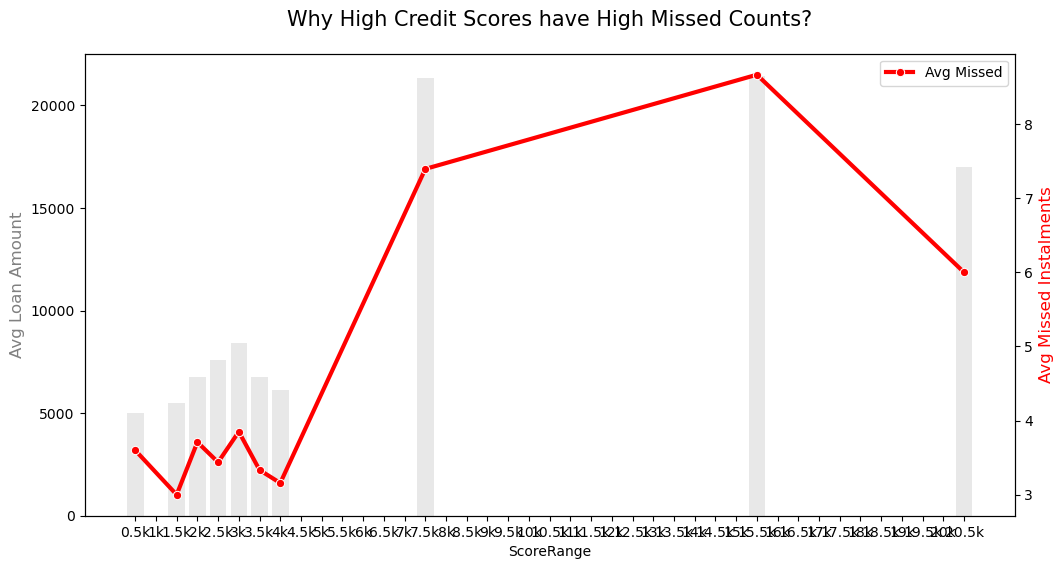

In [83]:
# Sumin - Does high credit score correlate with lower missed instalments?
# What can be read : 
# High credit scores are associated with higher average loan amounts.
# High credit scores are also associated with higher average missed instalments as the amount of loan is higher than lower credit scores.
# This suggests that high credit scores do not necessarily correlate with lower missed instalments.

# 1. Data preparation
bins = range(0, int(df['CreditScore'].max()) + 501, 500)
labels = [f'{b/1000:g}k' for b in bins[1:]]
df['ScoreRange'] = pd.cut(df['CreditScore'], bins=bins, labels=labels, right=False)

# 2. Average per group
analysis = df.groupby('ScoreRange', observed=True).agg({
    'MissedInstalments': 'mean',
    'AmountDisbursed': 'mean',
}).reset_index()

# 3. Visualization: Bar and Line Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart: Loan Amount (background)
sns.barplot(data=analysis, x='ScoreRange', y='AmountDisbursed', color='lightgray', alpha=0.5, ax=ax1)
ax1.set_ylabel('Avg Loan Amount', fontsize=12, color='gray')

# Line plot: Missed Instalments (foreground)
ax2 = ax1.twinx()
sns.lineplot(data=analysis, x='ScoreRange', y='MissedInstalments', color='red', marker='o', linewidth=3, ax=ax2, label='Avg Missed')
ax2.set_ylabel('Avg Missed Instalments', fontsize=12, color='red')

plt.title('Why High Credit Scores have High Missed Counts?', fontsize=15, pad=20)
plt.show()

# Hypothesis 03. The more client has ability to pay off(istead of making default micro finance), they will choose 5 weeks credit ease product.
as they are able to pay off in short term. ( 5 weeks > 10 weeks )

Conclusion : 5 weeks credit ease is most popular product and has largest group of default in proportion to number of client.
But out of number of client in each product, 10 weeks credit ease product makes miss instalments often comparing than 5 weeks, 7 weeks credit ease.
Interestingly, 7 weeks credit ease has highest default percentage among the products.

-> 5 weeks credit ease clients make less default in micro finance. / 10 weeks, 7 weeks has high risk to make default micro finance.

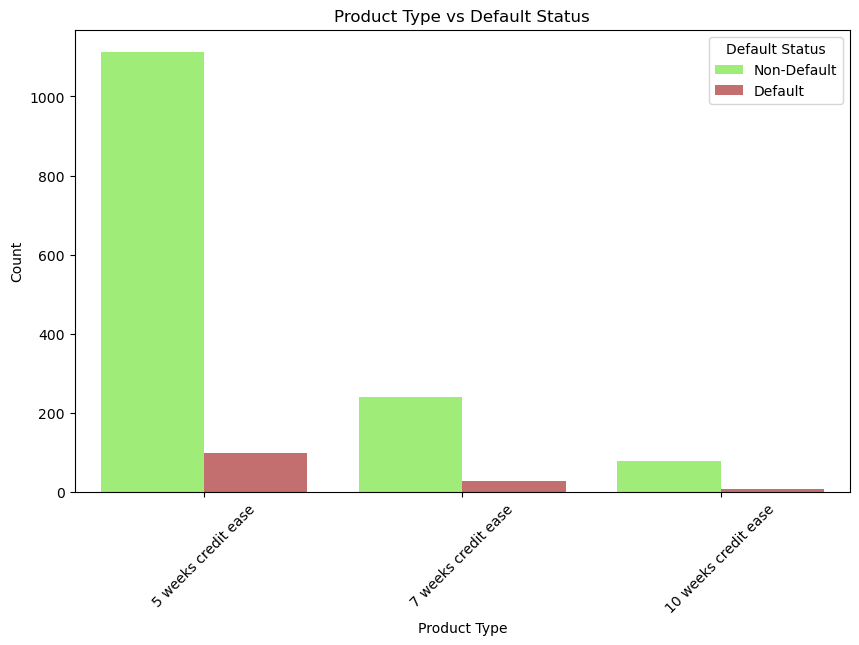

In [84]:
# James

# Analyze relationships between Product and the default
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Product', hue=defaulters, palette=["#99ff66","#d26161"])
plt.title('Product Type vs Default Status')
plt.xlabel('Product Type')
plt.ylabel('Count')
plt.legend(title='Default Status', labels=['Non-Default', 'Default'])
plt.xticks(rotation=45)
plt.show()

C:\Users\kunal\AppData\Local\Temp\ipykernel_20972\1051150638.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=product_risk, x='MissedInstalments', y='Product', palette='Reds_r')


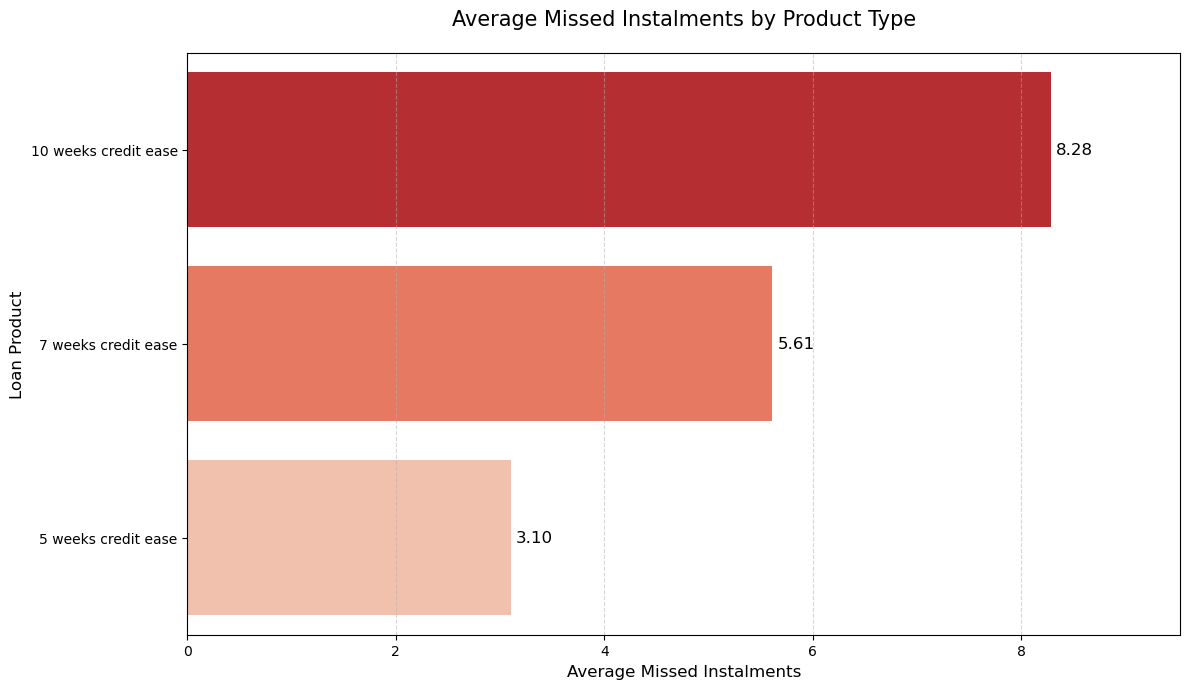

In [85]:
# Sumin, Kunal - Average Missed Instalments by product
# Borrowers who can repay quickly choose 5‑week products instead of 10‑week.
# Product choice reflects repayment capacity.
# Short‑term products may attract lower‑risk borrowers.
# 10 weeks credit ease has the highest average missed instalments
# Question: Why do clients opting for '10 weeks credit ease' tend to have higher missed instalments compared to other products?

# Visualization: Average Missed Instalments by product -> to detact Risky clients
product_risk = df.groupby('Product')['MissedInstalments'].mean().sort_values(ascending=False).reset_index()

# Visualization: Bar plot
plt.figure(figsize=(12, 7))
ax = sns.barplot(data=product_risk, x='MissedInstalments', y='Product', palette='Reds_r')


for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(width + 0.05,     
            p.get_y() + p.get_height()/2,
            f'{width:.2f}', 
            va='center',    
            fontsize=12, 
            fontweight='regular')

plt.title('Average Missed Instalments by Product Type', fontsize=15, pad=20)
plt.xlabel('Average Missed Instalments', fontsize=12)
plt.ylabel('Loan Product', fontsize=12)

plt.xlim(0, product_risk['MissedInstalments'].max() * 1.15)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

C:\Users\kunal\AppData\Local\Temp\ipykernel_20972\3783502285.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


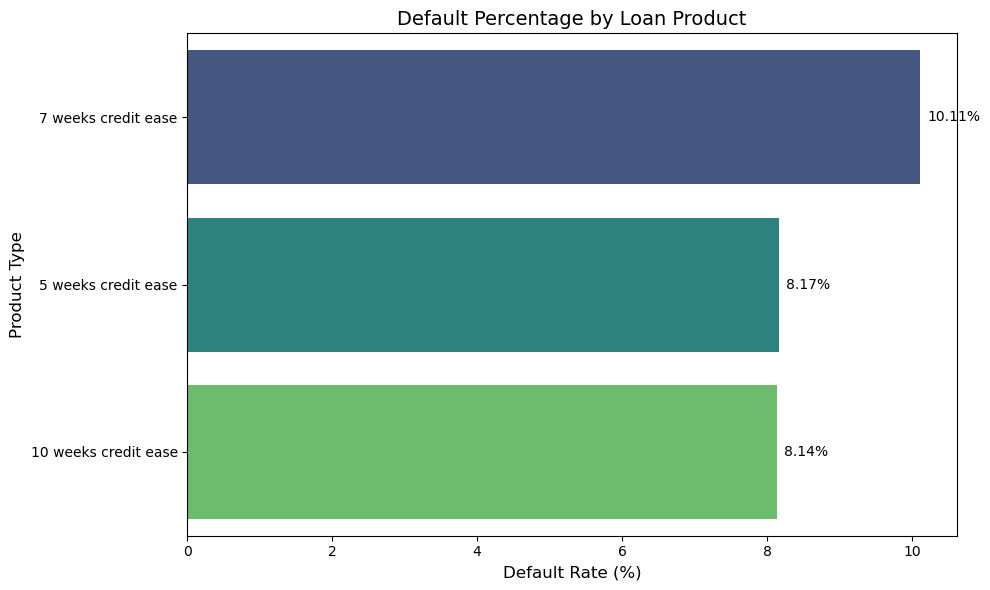

In [86]:
# James
# Introduce bool (1,0) for isDefault
df['IsDefault'] = defaulters

# Calculate default percentages per product type
# Group by Product and take the mean of the 'IsDefault' column
product_defaults = df.groupby('Product')['IsDefault'].mean().reset_index()
product_defaults['Default Percentage'] = product_defaults['IsDefault'] * 100

# Sort the data (descending) so the riskiest products are at the top
product_defaults = product_defaults.sort_values(by='Default Percentage', ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Default Percentage', 
    y='Product', 
    data=product_defaults, 
    palette='viridis'
)
plt.title('Default Percentage by Loan Product', fontsize=14)
plt.xlabel('Default Rate (%)', fontsize=12)
plt.ylabel('Product Type', fontsize=12)

# Add the actual percentage text next to each bar
for index, value in enumerate(product_defaults['Default Percentage']):
    plt.text(value + 0.1, index, f'{value:.2f}%', va='center')

plt.tight_layout()
plt.show()

C:\Users\kunal\AppData\Local\Temp\ipykernel_20972\1672467839.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=product_stats, x='Product', y='AvgBalance', palette='Blues_r', ax=ax1, alpha=0.7)


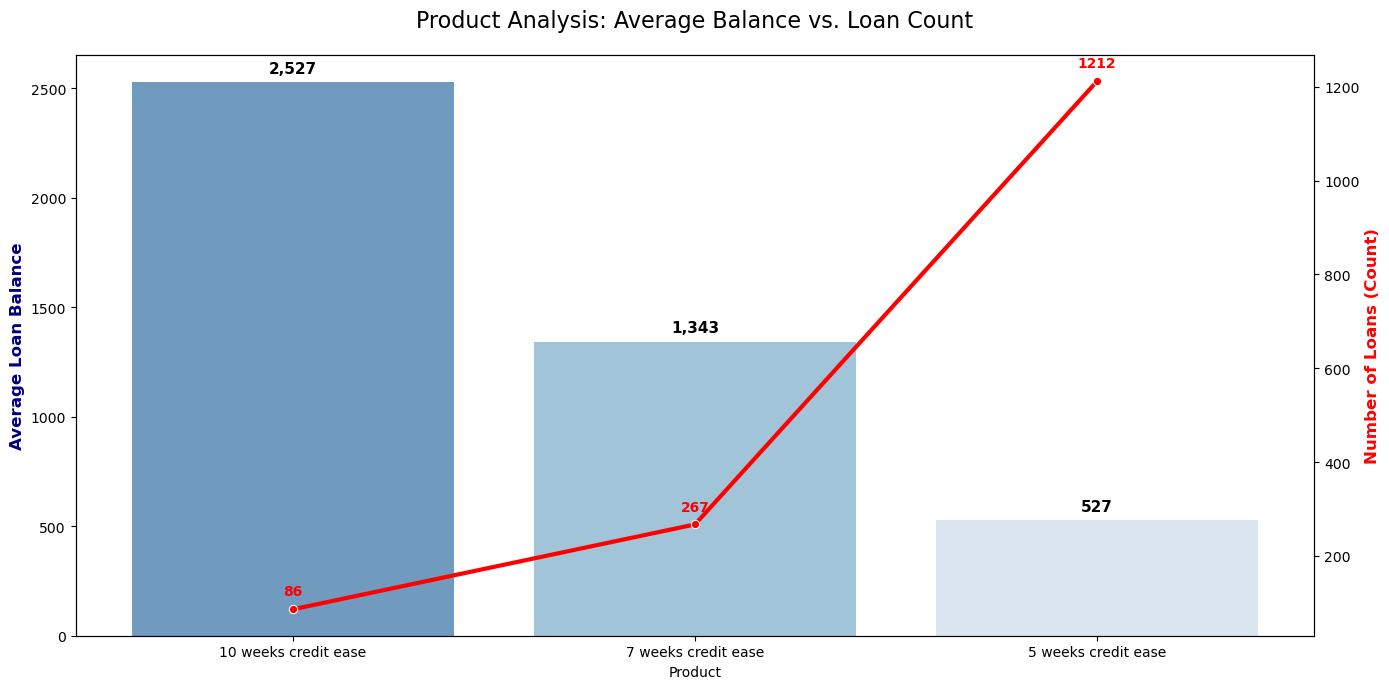

In [87]:
# Sumin - showing 10 weeks credit ease client tend to loan high amount but less clients.

# Calculate product statistics
product_stats = df.groupby('Product').agg(
    LoanCount=('LoanId', 'count'),
    AvgBalance=('LoanBalance', 'mean')
).sort_values(by='AvgBalance', ascending=False).reset_index()

# Visualization: Average Balance vs. Loan Count by Product
fig, ax1 = plt.subplots(figsize=(14, 7))

# Average Balance (Bar Chart)
sns.barplot(data=product_stats, x='Product', y='AvgBalance', palette='Blues_r', ax=ax1, alpha=0.7)
ax1.set_ylabel('Average Loan Balance', fontsize=12, fontweight='bold', color='navy')
ax1.set_title('Product Analysis: Average Balance vs. Loan Count', fontsize=16, pad=20)

# Number labels on top of bars
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():,.0f}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 10), 
                 textcoords='offset points', fontsize=11, fontweight='bold')

# number of Loans (Line Chart - Dual Axis)
ax2 = ax1.twinx() 
sns.lineplot(data=product_stats, x='Product', y='LoanCount', color='red', marker='o', linewidth=3, ax=ax2)
ax2.set_ylabel('Number of Loans (Count)', fontsize=12, fontweight='bold', color='red')

# Annotate Loan Count values
for i, txt in enumerate(product_stats['LoanCount']):
    ax2.annotate(txt, (product_stats['Product'][i], product_stats['LoanCount'][i]), 
                 textcoords="offset points", xytext=(0,10), ha='center', color='red', fontweight='bold')

plt.tight_layout()
plt.show()

# Hypothesis 04. The more client borrow large amont of loan, the higher possibility to make defaulty.

Conclusion : Contrary to expectations, client who borrow less amount of loan makes much defaulty than who borrow large amont of loan.

C:\Users\kunal\AppData\Local\Temp\ipykernel_20972\1784705482.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loan_amount_defaults = df.groupby('LoanAmountBin')['IsDefault'].mean().reset_index()
C:\Users\kunal\AppData\Local\Temp\ipykernel_20972\1784705482.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


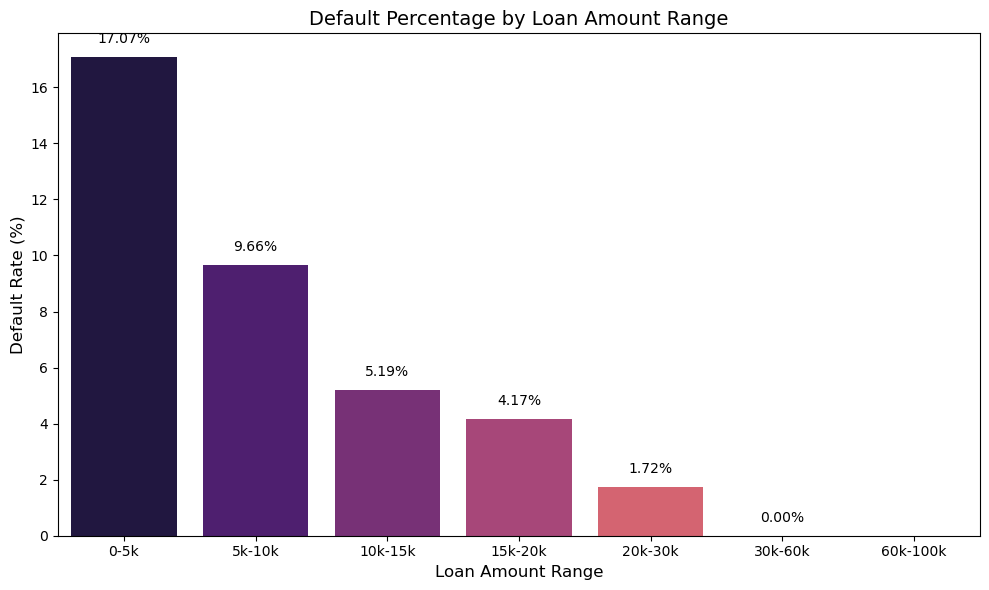

In [88]:
# James

# Analyze relationship between LoanAmount and IsDefault using a binned bar plot for differet loan ranges
# Define bins and labels for loan amounts
bins = [0, 5000, 10000, 15000, 20000, 30000, 60000, 100000] 
labels = ['0-5k', '5k-10k', '10k-15k', '15k-20k', '20k-30k', '30k-60k', '60k-100k']

# Create a new column for binned loan amounts
df['LoanAmountBin'] = pd.cut(df['AmountDisbursed'], bins=bins, labels=labels, right=False)

# Calculate the average default rate for each range
loan_amount_defaults = df.groupby('LoanAmountBin')['IsDefault'].mean().reset_index()
loan_amount_defaults['Default Percentage'] = loan_amount_defaults['IsDefault'] * 100
# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    x='LoanAmountBin', 
    y='Default Percentage', 
    data=loan_amount_defaults, 
    palette='magma'
)
plt.title('Default Percentage by Loan Amount Range', fontsize=14)
plt.xlabel('Loan Amount Range', fontsize=12)
plt.ylabel('Default Rate (%)', fontsize=12)
# Add the actual percentage text above each bar
for index, value in enumerate(loan_amount_defaults['Default Percentage']):
    plt.text(index, value + 0.5, f'{value:.2f}%', ha='center')  
plt.tight_layout()
plt.show()


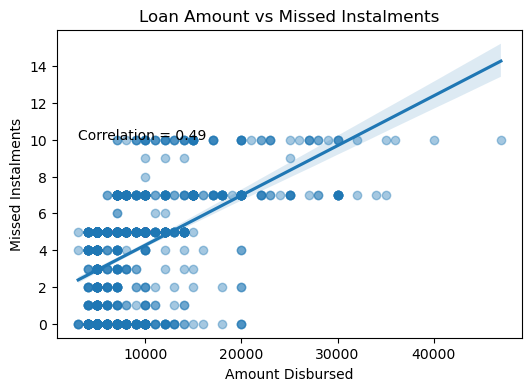

In [89]:
#Kunal
# Bigger loans create more repayment stress.
# Loan size is one of the strongest predictors of default in microfinance


plt.figure(figsize=(6,4))
sns.regplot(x='AmountDisbursed', y='MissedInstalments', data=df, scatter_kws={'alpha':0.4})
plt.xlabel("Amount Disbursed")
plt.ylabel("Missed Instalments")
plt.title("Loan Amount vs Missed Instalments")

corr = df['AmountDisbursed'].corr(df['MissedInstalments'])
plt.text(df['AmountDisbursed'].min(), df['MissedInstalments'].max(), f"Correlation = {corr:.2f}")

plt.show()

# Hypothesis 05. Risk of default micro finance is different by branch as their lifestlye, quality of life, average salary might be different.

Conclusion : Molo has higher miss instalments rate than Engineer, while default rate is lower than Engineer
** Good to look into why miss instalments doesn't have strong correlation with default at the end.

--- Default Rates by Branch (%) ---
Branch
engineer    18.20
molo         5.03
dtype: float64


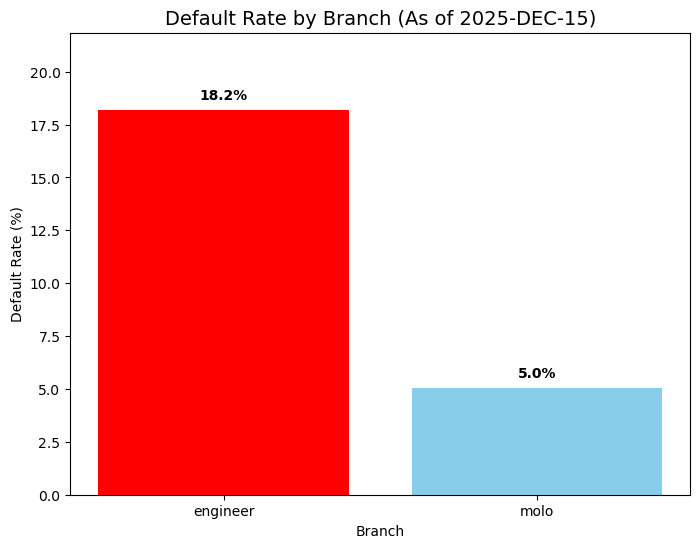

In [90]:
# James
# Visualizing the percentage of defaulters/number of loans based on branch as a chart

# Calculate Default Rate by Branch
branch_stats = defaulters.groupby(df['Branch']).mean() * 100

print("--- Default Rates by Branch (%) ---")
print(branch_stats.round(2))

# Visualization
plt.figure(figsize=(8, 6))
colors = ['red', 'skyblue']

plt.bar(branch_stats.index, branch_stats.values, color=colors)

plt.title('Default Rate by Branch (As of 2025-DEC-15)', fontsize=14)
plt.ylabel('Default Rate (%)')
plt.xlabel('Branch')
plt.ylim(0, max(branch_stats.values) * 1.2) 

for i, v in enumerate(branch_stats.values):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontweight='bold')

plt.show()

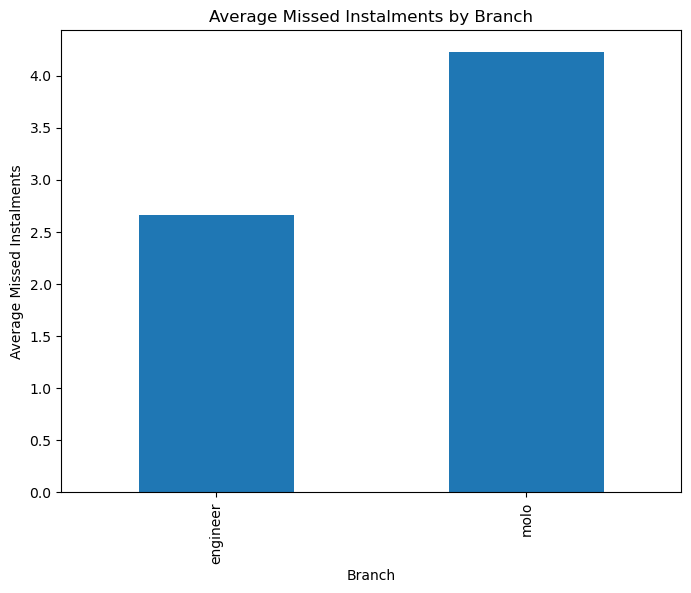

In [91]:
#Group analysis
average_misinstalments_by_branch = df.groupby('Branch')['MissedInstalments'].mean()

plt.figure(figsize=(8, 6))

average_misinstalments_by_branch.plot(kind='bar')

plt.xlabel('Branch')
plt.ylabel('Average Missed Instalments')
plt.title('Average Missed Instalments by Branch')

plt.show()

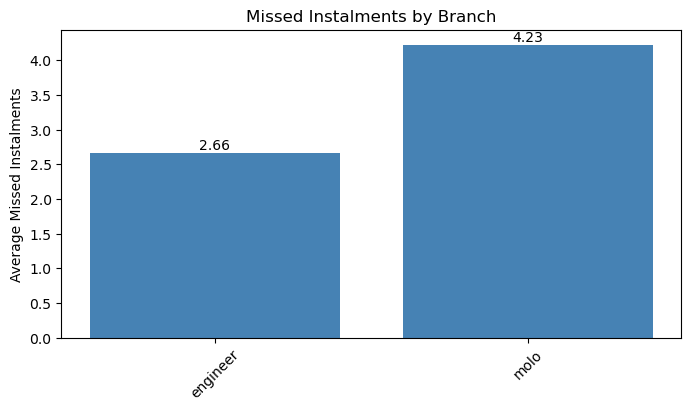

In [92]:
#Kunal
# Branches serve different communities with different economic conditions.
# Branch‑level insights help:
# - Identify high‑risk regions
# - Improve branch‑level training
# - Adjust loan policies

branch_missed = df.groupby('Branch')['MissedInstalments'].mean()

plt.figure(figsize=(8,4))
bars = plt.bar(branch_missed.index, branch_missed.values, color='steelblue')
plt.ylabel("Average Missed Instalments")
plt.title("Missed Instalments by Branch")
plt.xticks(rotation=45)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f"{yval:.2f}", ha='center')

plt.show()

# Hypothesis 06. Frequent client has high risk to make default micro finance.

Conclusion : 
Most clients use this microfinance service only 1–2 times, with very few exceeding 3 uses. Interestingly, clients who have used the product 5–6 times show a higher tendency to default compared to those in the 3–4 times range.

Customer loan counts:
 CustomerId
1048    16
484     15
1026    15
1000    14
1013    13
        ..
1757     1
1773     1
1775     1
1776     1
1777     1
Name: count, Length: 629, dtype: int64


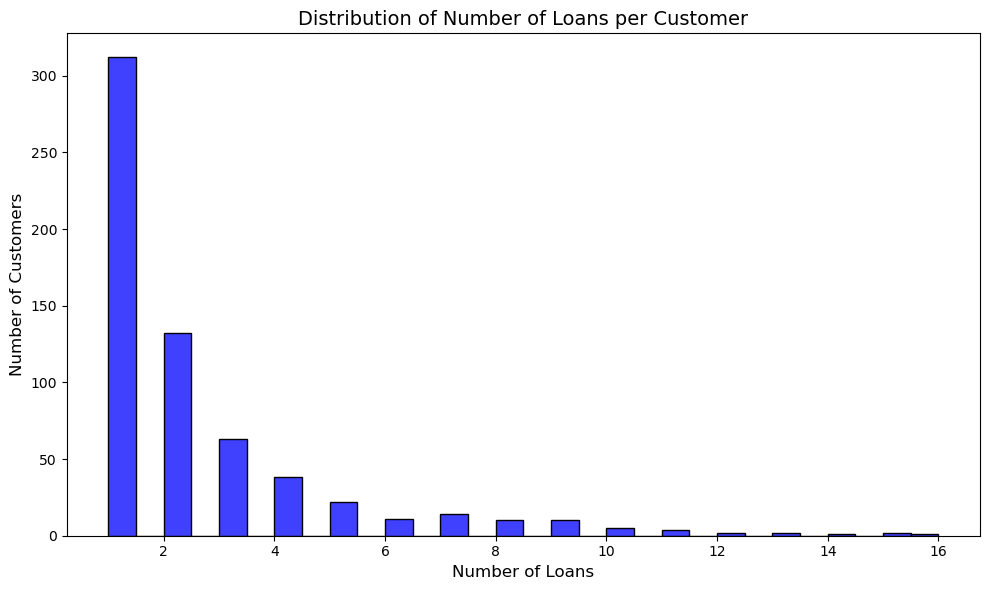

In [93]:
# James

# Get the customer loan counts based on CustomerId and plot as a histogram
customer_loan_counts = df['CustomerId'].value_counts()
print("Customer loan counts:\n", customer_loan_counts)
plt.figure(figsize=(10, 6))
sns.histplot(customer_loan_counts, bins=30, kde=False, color='blue')
plt.title('Distribution of Number of Loans per Customer', fontsize=14)
plt.xlabel('Number of Loans', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.tight_layout()
plt.show()

In [94]:
# Get the number of customers with 1 loan
single_loan_customers = customer_loan_counts[customer_loan_counts == 1].count()
print("Number of customers with 1 loan:", single_loan_customers)

Number of customers with 1 loan: 312


C:\Users\kunal\AppData\Local\Temp\ipykernel_20972\3148774744.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


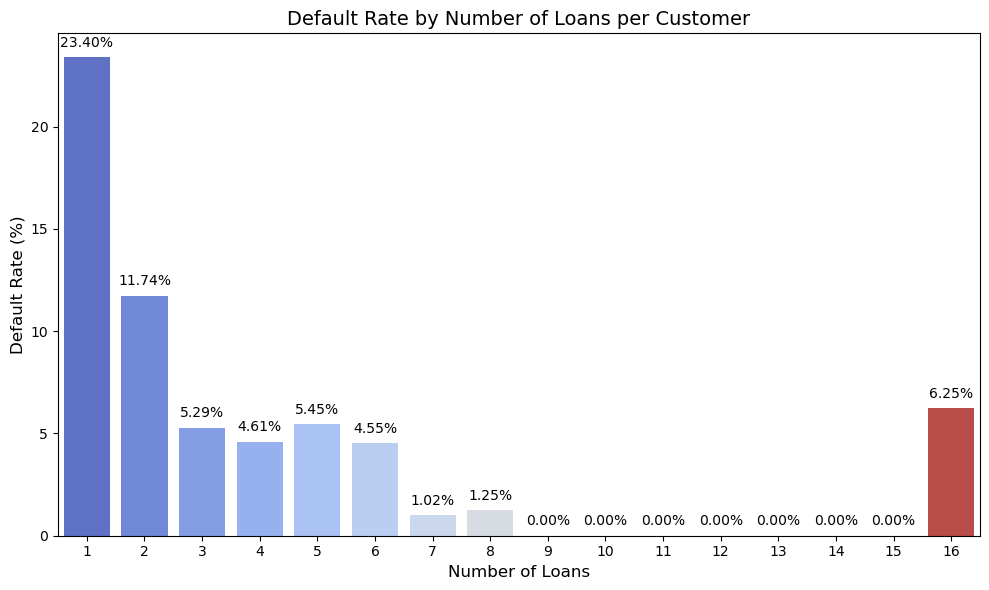

In [95]:
# Visualize the default rate based on the number of loans per customer as a bar plot
loan_count_defaults = df.groupby(df['CustomerId'].map(customer_loan_counts))['IsDefault'].mean().reset_index()
loan_count_defaults.columns = ['Number of Loans', 'Default Rate']
loan_count_defaults['Default Rate'] *= 100  
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Number of Loans', 
    y='Default Rate', 
    data=loan_count_defaults, 
    palette='coolwarm'
)
plt.title('Default Rate by Number of Loans per Customer', fontsize=14)
plt.xlabel('Number of Loans', fontsize=12)
plt.ylabel('Default Rate (%)', fontsize=12)
# Add the actual percentage text above each bar
for index, value in enumerate(loan_count_defaults['Default Rate']):
    plt.text(index, value + 0.5, f'{value:.2f}%', ha='center')
plt.tight_layout()
plt.show()

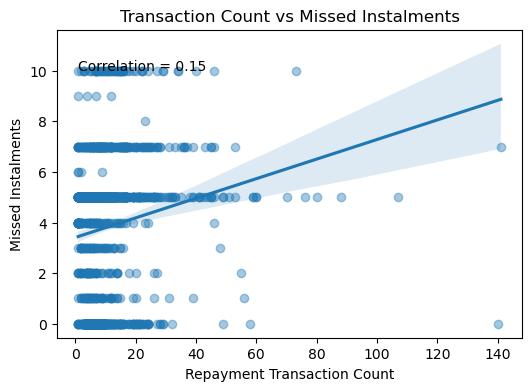

In [96]:
#Kunal
# High transaction frequency may indicate repayment struggles.
# Clients who frequently interact with the system may be:
# - Rescheduling payments
# - Making partial payments
# - Showing signs of financial stres

plt.figure(figsize=(6,4))
sns.regplot(x='loan_repayment_txn_count', y='MissedInstalments', data=df, scatter_kws={'alpha':0.4})
plt.xlabel("Repayment Transaction Count")
plt.ylabel("Missed Instalments")
plt.title("Transaction Count vs Missed Instalments")

corr = df['loan_repayment_txn_count'].corr(df['MissedInstalments'])
plt.text(df['loan_repayment_txn_count'].min(), df['MissedInstalments'].max(), f"Correlation = {corr:.2f}")

plt.show()

# Hypothesis 07. If client makes miss instalment or transaction frequently, they have high possibility to make default micro finance.

Conclusion : The frequency of missed installments and transaction counts correlates with the default rate, but the relationship is not linear
1. The highest default rate is among clients with 6 missed installments, while the second highest is surprisingly those with just 1 miss.
2. Clients with 0–4 transactions are at highest risk. Interestingly, risk increases to 13% once transactions exceed 50, whereas the 5–49 range shows the lowest risk.

Frequent borrowing can indicate:
- dependency on credit
- unstable cash flow
- repeated refinancing
- potential over‑indebtedness
Even though we don’t have a direct “loan count” column, we do have:
- CustomerId
- LoanId
We can test whether customers with multiple loans show higher default rates

C:\Users\kunal\AppData\Local\Temp\ipykernel_20972\3457303589.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


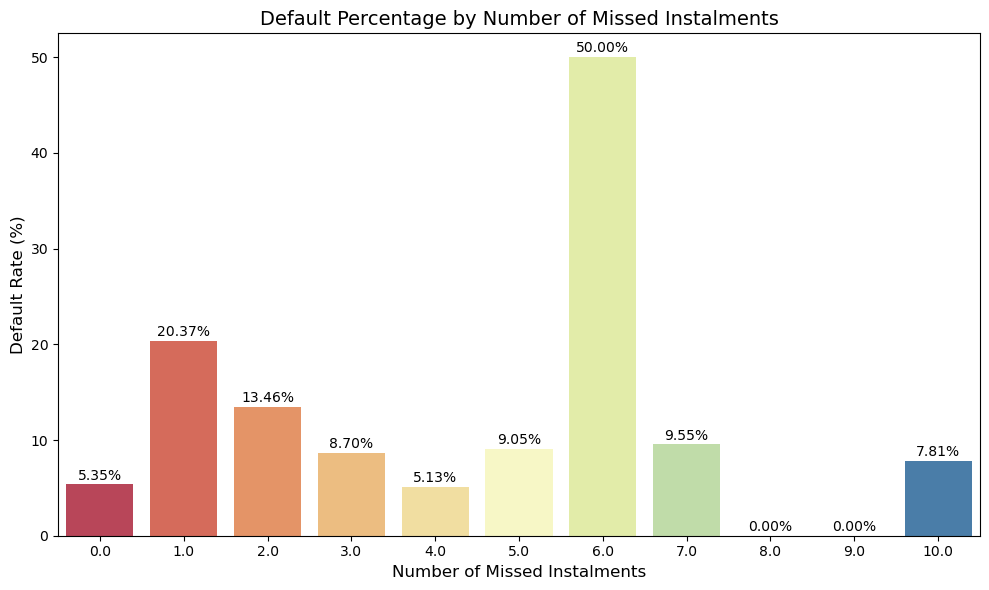

In [97]:
# James

# Visualize the relationship between MissedInstalments and IsDefault using a bar plot
missed_instalment_defaults = df.groupby('MissedInstalments')['IsDefault'].mean().reset_index()
missed_instalment_defaults['Default Percentage'] = missed_instalment_defaults['IsDefault'] * 100
plt.figure(figsize=(10, 6))
sns.barplot(
    x='MissedInstalments', 
    y='Default Percentage', 
    data=missed_instalment_defaults, 
    palette='Spectral'
)
plt.title('Default Percentage by Number of Missed Instalments', fontsize=14)
plt.xlabel('Number of Missed Instalments', fontsize=12)
plt.ylabel('Default Rate (%)', fontsize=12)
# Add the actual percentage text above each bar
for index, value in enumerate(missed_instalment_defaults['Default Percentage']):
    plt.text(index, value + 0.5, f'{value:.2f}%', ha='center')
plt.tight_layout()
plt.show()

C:\Users\kunal\AppData\Local\Temp\ipykernel_20972\592463311.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loan_repayment_defaults = df.groupby('LoanRepaymentTxnCountBin')['IsDefault'].mean().reset_index()
C:\Users\kunal\AppData\Local\Temp\ipykernel_20972\592463311.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


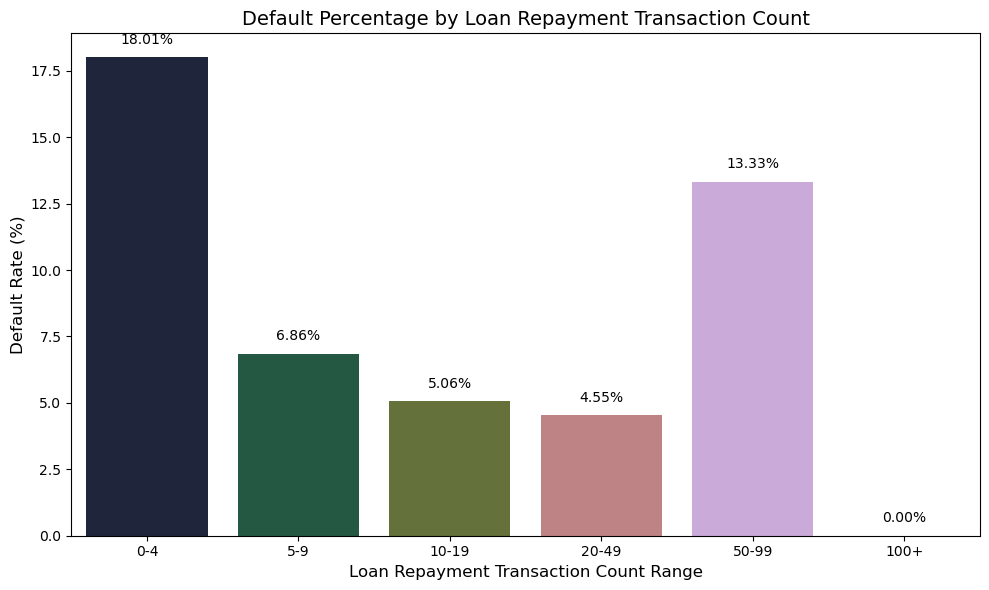

In [98]:
# Visualize the loan_repayment_txn_count against IsDefault using a bar plot in buckets
# Define bins and labels for loan repayment transaction counts
bins = [0, 5, 10, 20, 50, 100, 500]
labels = ['0-4', '5-9', '10-19', '20-49', '50-99', '100+']
# Create a new column for binned loan repayment transaction counts
df['LoanRepaymentTxnCountBin'] = pd.cut(df['loan_repayment_txn_count'], bins=bins, labels=labels, right=False)          
loan_repayment_defaults = df.groupby('LoanRepaymentTxnCountBin')['IsDefault'].mean().reset_index()
loan_repayment_defaults['Default Percentage'] = loan_repayment_defaults['IsDefault'] * 100
plt.figure(figsize=(10, 6))
sns.barplot(
    x='LoanRepaymentTxnCountBin', 
    y='Default Percentage', 
    data=loan_repayment_defaults, 
    palette='cubehelix'
)
plt.title('Default Percentage by Loan Repayment Transaction Count', fontsize=14)
plt.xlabel('Loan Repayment Transaction Count Range', fontsize=12)
plt.ylabel('Default Rate (%)', fontsize=12)
# Add the actual percentage text above each bar
for index, value in enumerate(loan_repayment_defaults['Default Percentage']):
    plt.text(index, value + 0.5, f'{value:.2f}%', ha='center')
plt.tight_layout()
plt.show()

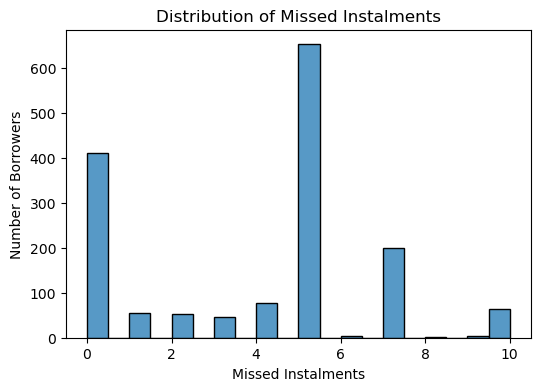

In [99]:
#Kunal
# Borrowers who miss instalments are more likely to default.
# Missed instalments are the strongest behavioural predictor of default.

plt.figure(figsize=(6,4))
sns.histplot(df['MissedInstalments'], bins=20)
plt.xlabel("Missed Instalments")
plt.ylabel("Number of Borrowers")
plt.title("Distribution of Missed Instalments")
plt.show()

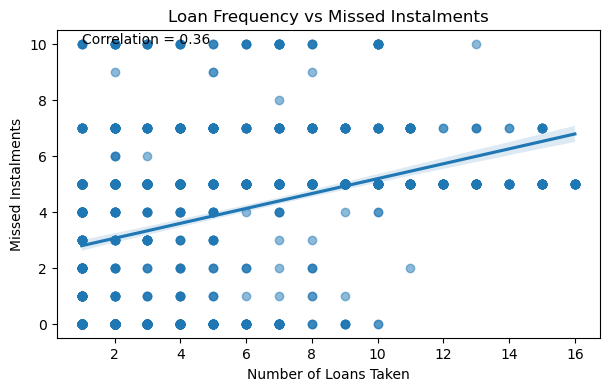

In [100]:
#Kunal
# If correlation is positive, frequent borrowers miss more instalments -> higher risk.
# If correlation is negative, frequent borrowers may be trusted repeat clients.
# Trendline shows the direction clearly.


# Step 1: Count loans per customer
loan_counts = df.groupby('CustomerId')['LoanId'].count().rename('LoanCount')

# Step 2: Merge back into main df
df_merged = df.merge(loan_counts, on='CustomerId')

# Step 3: Plot
plt.figure(figsize=(7,4))
sns.regplot(x='LoanCount', y='MissedInstalments',
            data=df_merged, scatter_kws={'alpha':0.5})
plt.xlabel("Number of Loans Taken")
plt.ylabel("Missed Instalments")
plt.title("Loan Frequency vs Missed Instalments")

corr = df_merged['LoanCount'].corr(df_merged['MissedInstalments'])
plt.text(df_merged['LoanCount'].min(),
         df_merged['MissedInstalments'].max(),
         f"Correlation = {corr:.2f}", fontsize=10)

plt.show()

# Hypothesis 08. Does a client's previous loan history significantly affect their likelihood of default?

Conclusion : 
1. Clients who fully cleared their previous loans show a higher default rate than those who had 1–5 missed installments.
2. Risk peaks for Cycle 3–4 clients, whereas the default rate drops significantly for those in Cycles 5–6.

C:\Users\kunal\AppData\Local\Temp\ipykernel_20972\2147900084.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rates = history_df.groupby('History_Group')['IsDefault'].mean() * 100
C:\Users\kunal\AppData\Local\Temp\ipykernel_20972\2147900084.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=default_rates.index, y=default_rates.values, palette='RdYlGn_r') # Red to Green color map


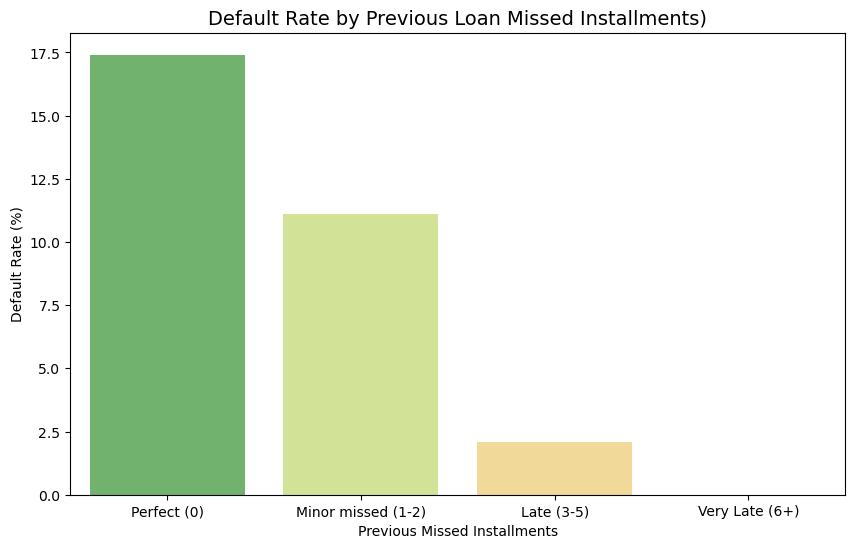

In [101]:
# James

# Sort by Customer and Date to ensure correct order
df = df.sort_values(by=['CustomerId', 'BorrowDate'])

# All loans are at least cycle 2 (the first loan is cycle 1, which we have removed during preprocessing)
# Calculate Loan Cycle (Cycle 2, 3, etc.)
df['Loan_Sequence'] = df.groupby('CustomerId').cumcount() + 2

# Look at the PREVIOUS loan's behavior for each customer
df['Prev_MissedInstalments'] = df.groupby('CustomerId')['MissedInstalments'].shift(1)
df['Prev_TxnCount'] = df.groupby('CustomerId')['loan_repayment_txn_count'].shift(1)

# We remove the first loan for each customer because they have no history to analyze
history_df = df.dropna(subset=['Prev_MissedInstalments', 'Prev_TxnCount']).copy()

# Visualize the relationship between previous missed installments and current default rate

plt.figure(figsize=(10, 6))

# Bin the missed installments into groups
# Groups of bins (perfect - no missed, minor missed, late, very late)
history_df['History_Group'] = pd.cut(history_df['Prev_MissedInstalments'], 
                                     bins=[-1, 0, 2, 5, 100], 
                                     labels=['Perfect (0)', 'Minor missed (1-2)', 'Late (3-5)', 'Very Late (6+)'])

# Calculate Default Rate per group
default_rates = history_df.groupby('History_Group')['IsDefault'].mean() * 100

# Plot
sns.barplot(x=default_rates.index, y=default_rates.values, palette='RdYlGn_r') # Red to Green color map
plt.title('Default Rate by Previous Loan Missed Installments)', fontsize=14)
plt.ylabel('Default Rate (%)')
plt.xlabel('Previous Missed Installments')
plt.show()

C:\Users\kunal\AppData\Local\Temp\ipykernel_20972\1029549691.py:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = history_df.pivot_table(index='Txn_Group', columns='History_Group', values='IsDefault', aggfunc='mean') * 100


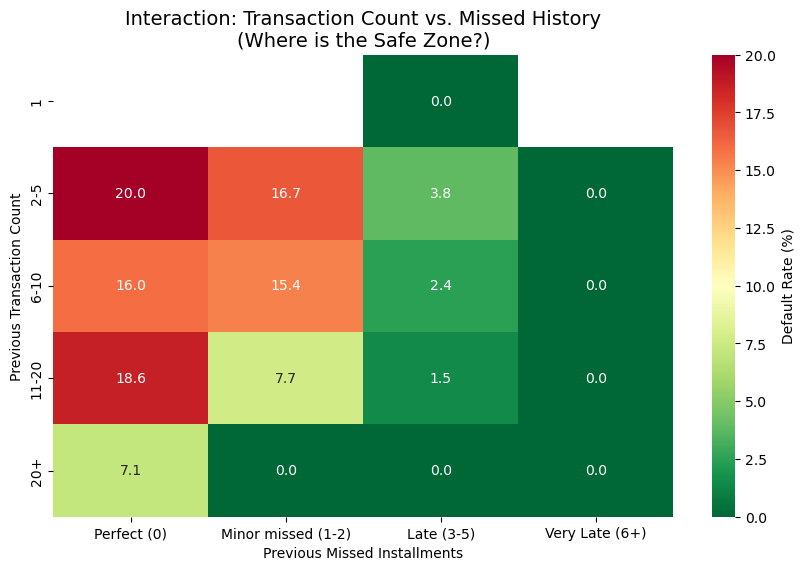

In [102]:
# Interaction: Transaction Count vs. Missed History Heatmap

# Bin Transaction Counts
history_df['Txn_Group'] = pd.cut(history_df['Prev_TxnCount'], 
                                 bins=[0, 1, 5, 10, 20, 100], 
                                 labels=['1', '2-5', '6-10', '11-20', '20+'])

# Create Pivot Table
pivot_table = history_df.pivot_table(index='Txn_Group', columns='History_Group', values='IsDefault', aggfunc='mean') * 100

# Plot Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap='RdYlGn_r', cbar_kws={'label': 'Default Rate (%)'})
plt.title('Interaction: Transaction Count vs. Missed History\n(Where is the Safe Zone?)', fontsize=14)
plt.ylabel('Previous Transaction Count')
plt.xlabel('Previous Missed Installments')
plt.show()

C:\Users\kunal\AppData\Local\Temp\ipykernel_20972\2711962718.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = history_df.pivot_table(index='Experience_Group', columns='History_Group', values='IsDefault', aggfunc='mean') * 100


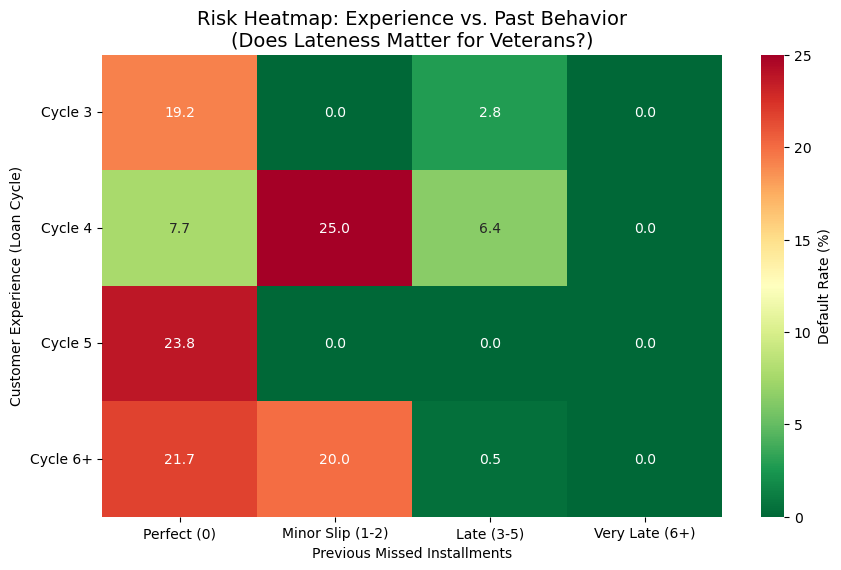

In [103]:
# Experience: Loan Cycle vs. Missed History Heatmap

# 4. Create Bins
# Behavior Bins
history_df['History_Group'] = pd.cut(history_df['Prev_MissedInstalments'], 
                                     bins=[-1, 0, 2, 5, 100], 
                                     labels=['Perfect (0)', 'Minor Slip (1-2)', 'Late (3-5)', 'Very Late (6+)'])

# Experience Bins (Loan Cycles)
history_df['Experience_Group'] = pd.cut(history_df['Loan_Sequence'], 
                                      bins=[1.9, 2.9, 3.9, 4.9, 5.9, 100], 
                                      labels=['Cycle 2', 'Cycle 3', 'Cycle 4', 'Cycle 5', 'Cycle 6+'])

# 5. Create Heatmap
pivot_table = history_df.pivot_table(index='Experience_Group', columns='History_Group', values='IsDefault', aggfunc='mean') * 100

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap='RdYlGn_r', cbar_kws={'label': 'Default Rate (%)'})
plt.title('Risk Heatmap: Experience vs. Past Behavior\n(Does Lateness Matter for Veterans?)', fontsize=14)
plt.ylabel('Customer Experience (Loan Cycle)')
plt.xlabel('Previous Missed Installments')
plt.yticks(rotation=0)
plt.show()

C:\Users\kunal\AppData\Local\Temp\ipykernel_20972\619619442.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  late_risk = history_df[history_df['Is_Late']].groupby('Sequence_Group')['IsDefault'].mean() * 100


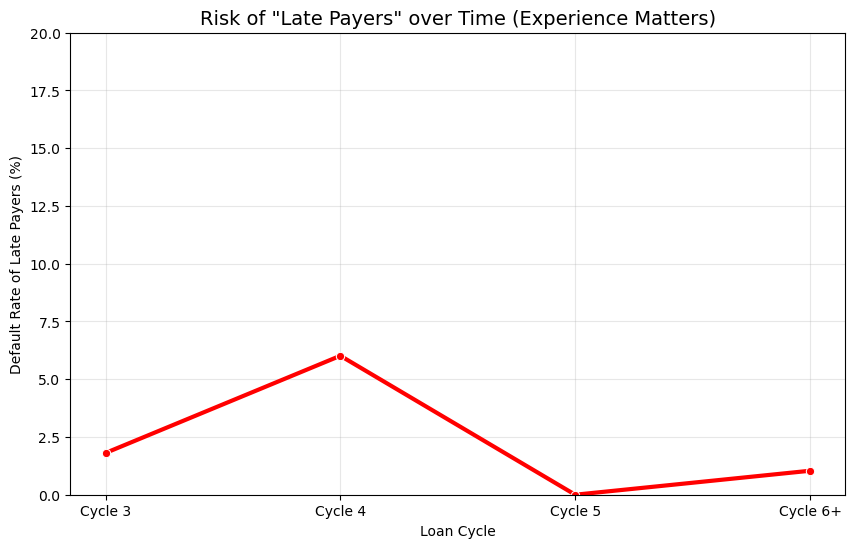

In [104]:
# Experience: Loan Cycle vs. Late Payers Line Plot
# Bin Loan Sequence
history_df['Sequence_Group'] = pd.cut(history_df['Loan_Sequence'], 
                                      bins=[1.9, 2.9, 3.9, 4.9, 5.9, 100], 
                                      labels=['Cycle 2', 'Cycle 3', 'Cycle 4', 'Cycle 5', 'Cycle 6+'])

# Flag Late Payers
history_df['Is_Late'] = history_df['Prev_MissedInstalments'] > 0

# Calculate Risk ONLY for Late Payers
late_risk = history_df[history_df['Is_Late']].groupby('Sequence_Group')['IsDefault'].mean() * 100

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=late_risk.index, y=late_risk.values, marker='o', color='red', linewidth=3)
plt.title('Risk of "Late Payers" over Time (Experience Matters)', fontsize=14)
plt.ylabel('Default Rate of Late Payers (%)')
plt.xlabel('Loan Cycle')
plt.ylim(0, 20) # Set limit to see the drop clearly
plt.grid(True, alpha=0.3)
plt.show()

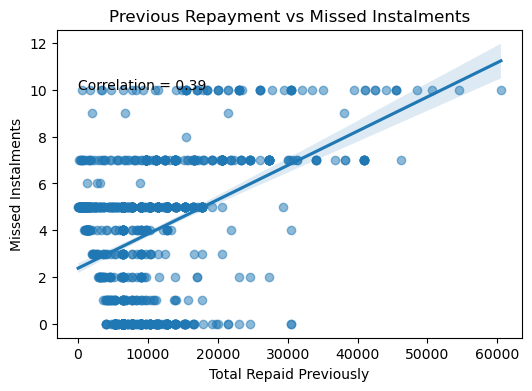

In [105]:
#Kunal
# Borrowers with poor repayment history are more likely to default again.
# Repayment behaviour is highly predictive of future performance.

plt.figure(figsize=(6,4))
sns.regplot(x='loan_repayment_total_paid', y='MissedInstalments', data=df, scatter_kws={'alpha':0.5})
plt.xlabel("Total Repaid Previously")
plt.ylabel("Missed Instalments")
plt.title("Previous Repayment vs Missed Instalments")

corr = df['loan_repayment_total_paid'].corr(df['MissedInstalments'])
plt.text(df['loan_repayment_total_paid'].min(), df['MissedInstalments'].max(), f"Correlation = {corr:.2f}")

plt.show()

# Hypothesis 09. Do Late Payers have higher capacity?

Conclusion : Most of clients make late payment than perfect weekly payment. cliente who has higher Loan limite tend to make late payment.

C:\Users\kunal\AppData\Local\Temp\ipykernel_20972\1787084686.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Payer_Style', y='LoanLimit', data=history_df, palette='Set2')


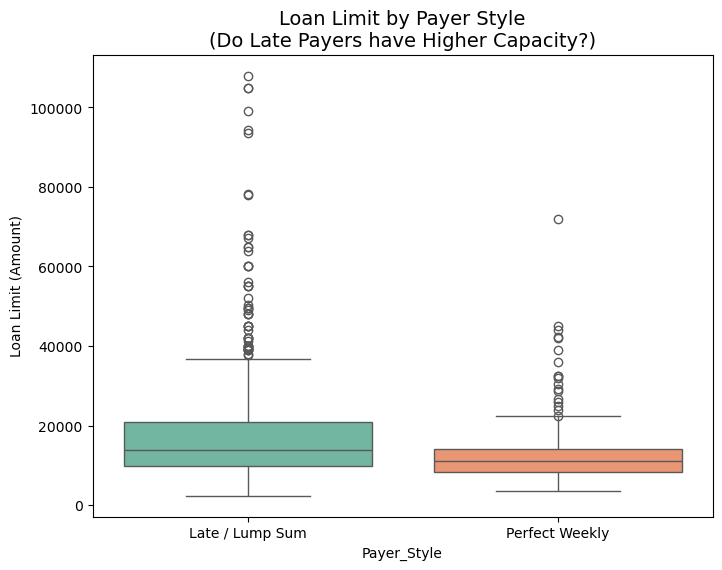

In [106]:
# James

# Capacity: Loan Limit vs. Payer Style Box Plot

# Define Payer Style
history_df['Payer_Style'] = history_df['Prev_MissedInstalments'].apply(lambda x: 'Late / Lump Sum' if x > 0 else 'Perfect Weekly')

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Payer_Style', y='LoanLimit', data=history_df, palette='Set2')
plt.title('Loan Limit by Payer Style\n(Do Late Payers have Higher Capacity?)', fontsize=14)
plt.ylabel('Loan Limit (Amount)')
plt.show()

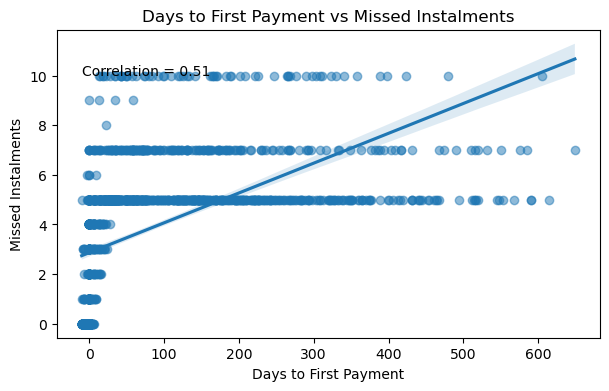

In [107]:
#Kunal
# Borrowers who delay first payment may be managing cash flow strategically.
# Days to first payment reflects:
# - Liquidity
# - Cash flow stability
# - Repayment discipline
# If correlation is positive, late payers miss more instalments -> lower capacity.
# If correlation is negative, late payers may actually be more disciplined.
# Trendline helps interpret the relationship.

plt.figure(figsize=(7,4))
sns.regplot(x='days_to_first', y='MissedInstalments',
            data=df, scatter_kws={'alpha':0.5})
plt.xlabel("Days to First Payment")
plt.ylabel("Missed Instalments")
plt.title("Days to First Payment vs Missed Instalments")


corr = df['days_to_first'].corr(df['MissedInstalments'])
plt.text(df['days_to_first'].min(),
         df['MissedInstalments'].max(),
         f"Correlation = {corr:.2f}", fontsize=10)

plt.show()

# Hypothesis 10. Does business type impact to make defaulty?

Conclusion : 
1. Top 25% clients who has high credit score but has many missed instalments tend to borrow big amount of loan than others customers.
2. Agriculture, green grocery business owener has higher risk to make defaulty (but cannot generalized)

High credit score but missed instalments clients: 503


C:\Users\kunal\AppData\Local\Temp\ipykernel_20972\1474997351.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=high_risk_prime, y='BusinessType',


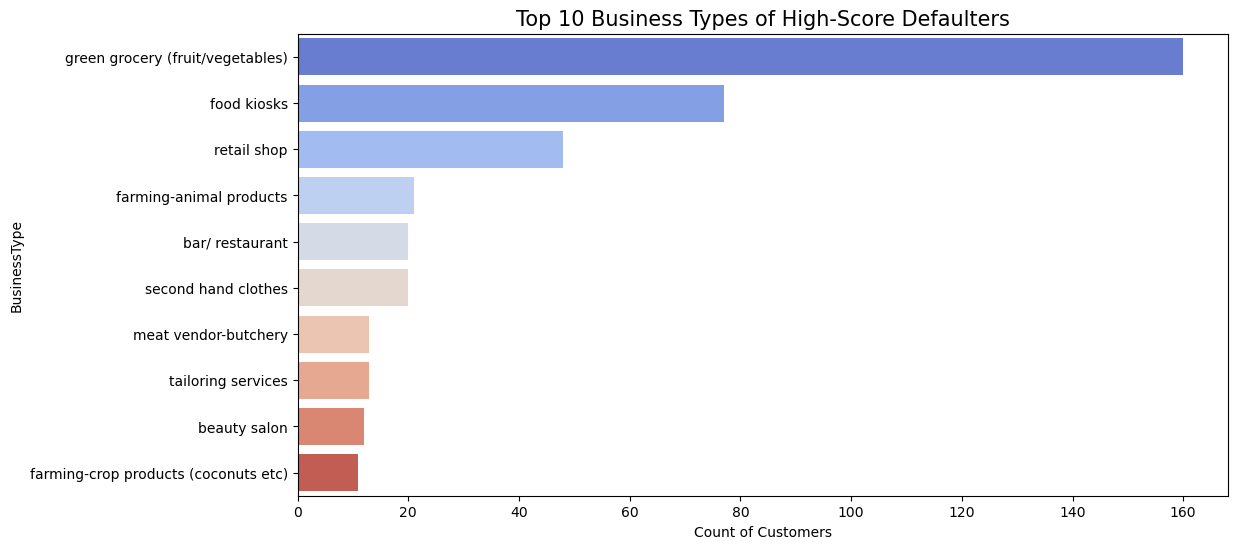

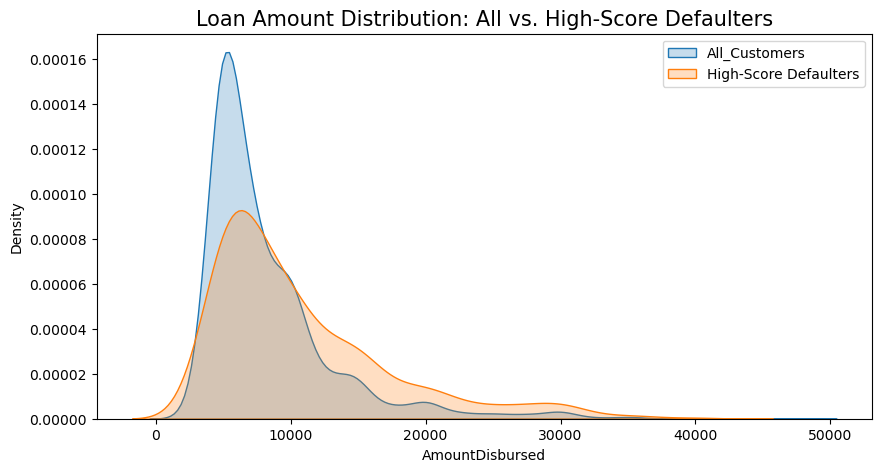

In [108]:
# Sumin

# High Credit Score but High Missed Instalments Analysis
high_score_threshold = df['CreditScore'].quantile(0.75)  # Top 25% credit score
high_missed_threshold = df['MissedInstalments'].mean()   # Average missed instalments

high_risk_prime = df[(df['CreditScore'] >= high_score_threshold) & 
                     (df['MissedInstalments'] > high_missed_threshold)].copy()

print(f"High credit score but missed instalments clients: {len(high_risk_prime)}")

# Visualization their business types
plt.figure(figsize=(12, 6))
sns.countplot(data=high_risk_prime, y='BusinessType', 
              order=high_risk_prime['BusinessType'].value_counts().iloc[:10].index,
              palette='coolwarm')

plt.title('Top 10 Business Types of High-Score Defaulters', fontsize=15)
plt.xlabel('Count of Customers')
plt.show()

# Visualization: Loan Amount Distribution - All vs. High-Score Defaulters
plt.figure(figsize=(10, 5))
sns.kdeplot(df['AmountDisbursed'], label='All_Customers', fill=True)
sns.kdeplot(high_risk_prime['AmountDisbursed'], label='High-Score Defaulters', fill=True)

plt.title('Loan Amount Distribution: All vs. High-Score Defaulters', fontsize=15)
plt.legend()
plt.show()

--- Industry Summary Statistics ---
                                  Avg_Loan_Amount  Avg_Repayment_Days  \
Industry                                                                
education                            20000.000000           77.500000   
transportation                       10119.047619           54.404762   
wholesale & retail trade              9324.324324           36.918919   
manufacturing                         9285.714286           36.142857   
fashion & beauty products             8923.566879           43.184713   
agriculture                           8369.230769           45.892308   
food & hospitality                    8288.190683           43.643554   
automobile services                   8222.222222           23.333333   
business & information                8142.857143           53.285714   
natural resources/environmental       7837.837838           34.837838   
agriculture, forestry & fishing       7814.814815           37.370370   
real estate & h

C:\Users\kunal\AppData\Local\Temp\ipykernel_20972\2426686687.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df, x='Industry', y='RepaymentDuration', palette='viridis', errorbar=None)


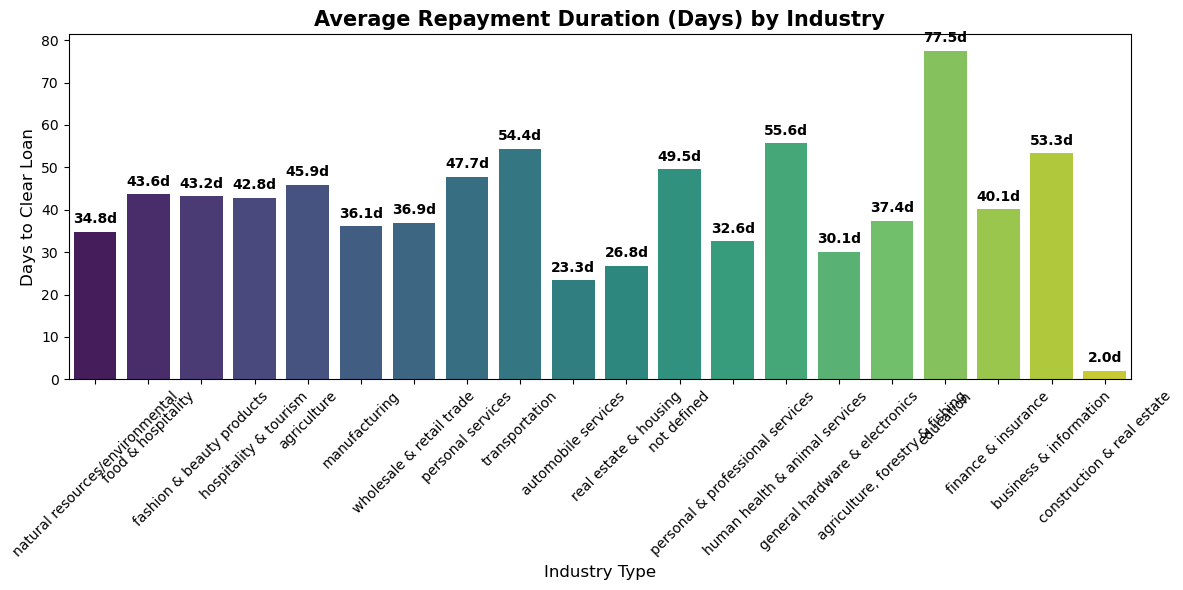

In [109]:
# 1. Feature Engineering: Calculating Repayment Duration
# Converting to datetime to ensure accurate calculation
df['BorrowDate'] = pd.to_datetime(df['BorrowDate'])
df['ClearDate'] = pd.to_datetime(df['ClearDate'])

# Repayment duration in days
df['RepaymentDuration'] = (df['ClearDate'] - df['BorrowDate']).dt.days

# 2. Aggregating Statistics by Industry
# We analyze the average loan size, repayment speed, and total volume
industry_summary = df.groupby('Industry').agg({
    'AmountDisbursed': 'mean',
    'RepaymentDuration': 'mean',
    'LoanId': 'count'
}).rename(columns={
    'AmountDisbursed': 'Avg_Loan_Amount',
    'RepaymentDuration': 'Avg_Repayment_Days',
    'LoanId': 'Total_Loan_Count'
}).sort_values(by='Avg_Loan_Amount', ascending=False)

print("--- Industry Summary Statistics ---")
print(industry_summary)

# 3. Visualization: Average Repayment Duration by Industry
# Bar chart to compare how long each industry takes to clear their debt
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df, x='Industry', y='RepaymentDuration', palette='viridis', errorbar=None)

# Adding value labels on top of the bars for clarity
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}d', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 9), 
                textcoords='offset points', fontsize=10, fontweight='bold')

plt.xticks(rotation=45)
plt.title('Average Repayment Duration (Days) by Industry', fontsize=15, fontweight='bold')
plt.xlabel('Industry Type', fontsize=12)
plt.ylabel('Days to Clear Loan', fontsize=12)

plt.tight_layout()
plt.savefig('industry_repayment_duration.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\kunal\AppData\Local\Temp\ipykernel_20972\3401517482.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=business_analysis.head(10), x='Default_Clients', y='BusinessType', palette='magma')


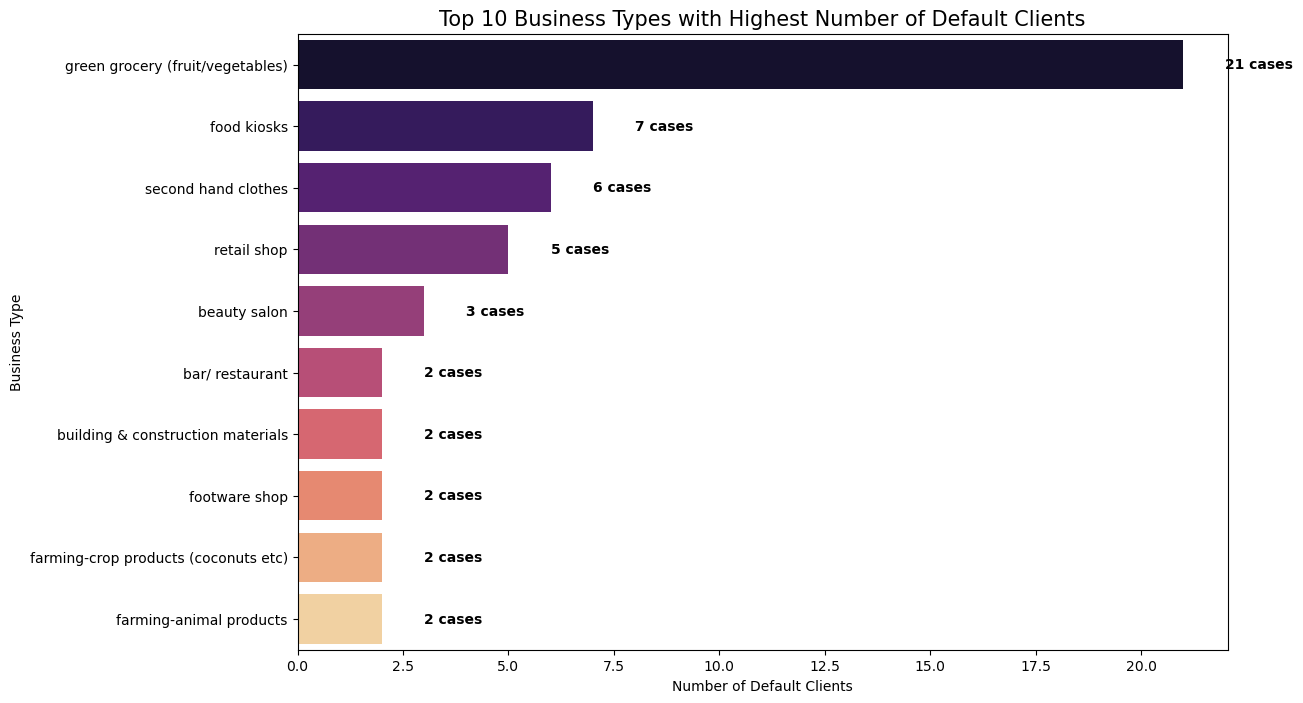

                            BusinessType  Total_Clients  Default_Clients  \
22      green grocery (fruit/vegetables)            492               21   
20                           food kiosks            212                7   
42                   second hand clothes             72                6   
40                           retail shop            139                5   
5                           beauty salon             41                3   
3                        bar/ restaurant             71                2   
7      building & construction materials             20                2   
21                         footware shop             19                2   
18  farming-crop products (coconuts etc)             30                2   
17               farming-animal products             58                2   

    Default_Rate_%  
22        4.268293  
20        3.301887  
42        8.333333  
40        3.597122  
5         7.317073  
3         2.816901  
7        10.0000

In [110]:
# 1. Assuming 'Default' column is already created by your teammate
# If not, we use the logic: (df['ClearDate'] > '2025-12-15') & (df['LoanBalance'] > 0)
if 'Default' not in df.columns:
    df['Default'] = ((df['ClearDate'] > '2025-12-15') & (df['LoanBalance'] > 0)).astype(int)

# 2. Group by BusinessType to get total and default counts
business_analysis = df.groupby('BusinessType').agg(
    Total_Clients=('LoanId', 'count'),
    Default_Clients=('Default', 'sum')
).reset_index()

# 3. Calculate Default Rate (%) for better context
business_analysis['Default_Rate_%'] = (business_analysis['Default_Clients'] / business_analysis['Total_Clients']) * 100
business_analysis = business_analysis.sort_values(by='Default_Clients', ascending=False)

# 4. Visualize the top 10 Business Types with most Defaulters
plt.figure(figsize=(12, 8))
sns.barplot(data=business_analysis.head(10), x='Default_Clients', y='BusinessType', palette='magma')

# Add value labels
for i, val in enumerate(business_analysis.head(10)['Default_Clients']):
    plt.text(val + 1, i, f'{int(val)} cases', va='center', fontweight='bold')

plt.title('Top 10 Business Types with Highest Number of Default Clients', fontsize=15)
plt.xlabel('Number of Default Clients')
plt.ylabel('Business Type')
plt.show()

# Display the table
print(business_analysis[['BusinessType', 'Total_Clients', 'Default_Clients', 'Default_Rate_%']].head(10))

In [111]:
#Kunal

# The table is sorted from highest to lowest missed instalments.
# Business types at the top show higher repayment stress.
# This helps identify riskier industries for microfinance lending and portfolio management.


business_table = (
    df.groupby('BusinessType')['MissedInstalments']
      .mean()
      .reset_index()
      .rename(columns={
          'BusinessType': 'Business Type',
          'MissedInstalments': 'Average Missed Instalments'
      })
      .sort_values(by='Average Missed Instalments', ascending=False)
      .reset_index(drop=True)
)

business_table

,Business Type,Average Missed Instalments
0,oil & gas distribution,7.000000
1,water vending,6.500000
2,private school,5.250000
3,contractor/plumbing & interior design,5.000000
4,lawn care services,5.000000
5,taxi & rental services,5.000000
6,household utensils,5.000000
7,farming-animal products,4.431034
8,beverage manufacturing- juice etc,4.400000
9,agro-vet,4.400000


# Hypothesis 11 — Clients With Higher Loan Balance Are More Likely to Default
A high LoanBalance means the borrower still owes a large amount.
This can indicate:
- repayment difficulty
- poor cash flow
- delayed instalments
- risk of future default
Microfinance institutions often monitor outstanding balance as a key risk indicator

Conclusion : If defaulters have higher remaining balances, the hypothesis is supported. If balances are similar, loan balance may not be a strong predictor.

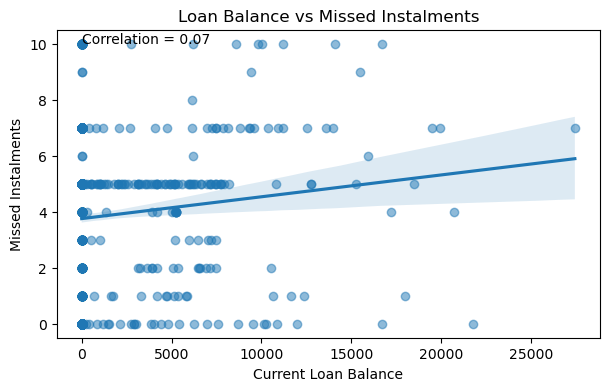

In [112]:
#Kunal
# A positive correlation supports the hypothesis: higher remaining balance -> more missed instalments.
# Trendline shows whether the relationship is strong or weak.

plt.figure(figsize=(7,4))
sns.regplot(x='LoanBalance', y='MissedInstalments',
            data=df, scatter_kws={'alpha':0.5})
plt.xlabel("Current Loan Balance")
plt.ylabel("Missed Instalments")
plt.title("Loan Balance vs Missed Instalments")

corr = df['LoanBalance'].corr(df['MissedInstalments'])
plt.text(df['LoanBalance'].min(),
         df['MissedInstalments'].max(),
         f"Correlation = {corr:.2f}", fontsize=10)

plt.show()

# Feature Understanding

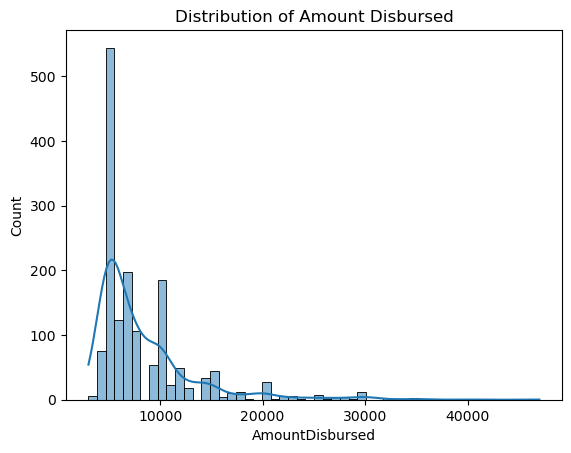

count     1565.000000
mean      8298.402556
std       5048.843655
min       3000.000000
25%       5000.000000
50%       7000.000000
75%      10000.000000
max      47000.000000
Name: AmountDisbursed, dtype: float64

In [113]:
# Histogram shows whether loan amounts cluster around certain values.
# Summary stats show typical loan sizes.
# Outliers may indicate special loan products or data errors.

sns.histplot(df['AmountDisbursed'], kde=True)
plt.title("Distribution of Amount Disbursed")
plt.show()

df['AmountDisbursed'].describe()


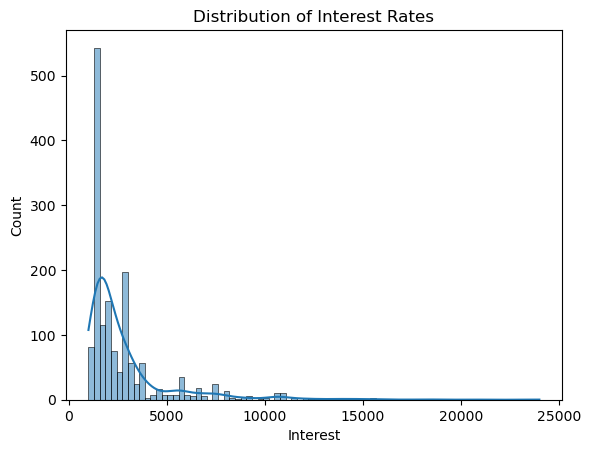

count     1565.000000
mean      2819.137380
std       2385.688941
min       1000.000000
25%       1500.000000
50%       2000.000000
75%       2800.000000
max      24000.000000
Name: Interest, dtype: float64

In [114]:
# Helps identify whether interest rates vary widely.
# High variance may indicate different risk tiers or products.
# Skewness may show preferential pricing.

sns.histplot(df['Interest'], kde=True)
plt.title("Distribution of Interest Rates")
plt.show()

df['Interest'].describe()

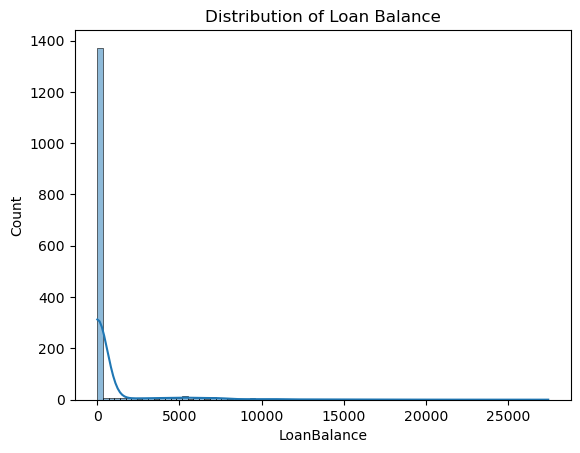

In [115]:
# High balances may indicate repayment difficulty.
# Compare with MissedInstalments later to test risk.

sns.histplot(df['LoanBalance'], kde=True)
plt.title("Distribution of Loan Balance")
plt.show()

In [116]:
# Numeric Feature Understanding

numeric_cols = df.select_dtypes(include=['int64','float64']).columns
df[numeric_cols].describe()

# Mean vs Median - If far apart -> skewed distribution
# High standard deviation
# Feature varies a lot across borrowers
# Very high max values
# Possible outliers
# Low min values
# Possible data entry issues

# Numeric features like AmountDisbursed, Interest, LoanBalance, CreditScore directly influence repayment behaviour.
# Understanding their distribution helps detect: risk patterns, unusual borrower segments, data quality issues

# General insights
# Skewed distributions: If mean != median, the feature is skewed
# Outliers: If max is much higher than 75%, we have outliers
# Zero-heavy features: If 25% and 50% are zero (like LoanBalance), many borrowers have cleared their loans


#for example: AmountDisbursed
# Mean: ₹8,298
# Min–Max: ₹3,000 to ₹47,000
# Std Dev: ₹5,048 -> high spread
# Median (50%): ₹7,000
# Interpretation:
# Most loans are between ₹5,000 and ₹10,000
# Some outliers go up to ₹47,000
# You might want to cap or log-transform this for modelling


,LoanId,AmountDisbursed,Interest,LoanBalance,CustomerId,LoanLimit,CreditScore,loan_repayment_txn_count,loan_repayment_total_paid,loan_overpayment,MissedInstalments,YearEstablished,days_to_first,IsDefault,Loan_Sequence,Prev_MissedInstalments,Prev_TxnCount,RepaymentDuration,Default
count,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,1565.000000,936.000000,936.000000,1565.000000,1565.000000
mean,781312.334824,8298.402556,2819.137380,775.723425,1159.578914,14378.913738,2689.968051,10.486262,9848.112460,66.336102,3.814058,2017.888179,79.073482,0.084984,3.930990,3.986111,12.177350,43.362939,0.040895
std,85936.623389,5048.843655,2385.688941,2630.902989,348.861634,11127.649952,2456.747650,10.814909,7326.545661,594.631286,2.786165,2.971027,118.994263,0.278947,2.589639,2.809613,11.775283,63.444842,0.198109
min,639200.000000,3000.000000,1000.000000,0.000000,23.000000,2400.000000,0.000000,1.000000,40.000000,0.000000,0.000000,2010.000000,-10.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000
25%,703557.000000,5000.000000,1500.000000,0.000000,980.000000,8000.000000,2000.000000,5.000000,6500.000000,0.000000,0.000000,2016.000000,0.000000,0.000000,2.000000,0.000000,6.000000,1.000000,0.000000
50%,778899.000000,7000.000000,2000.000000,0.000000,1136.000000,11000.000000,2000.000000,7.000000,7750.000000,0.000000,5.000000,2018.000000,23.000000,0.000000,3.000000,5.000000,9.000000,12.000000,0.000000
75%,846838.000000,10000.000000,2800.000000,0.000000,1425.000000,16200.000000,2500.000000,13.000000,12750.000000,0.000000,5.000000,2020.000000,123.000000,0.000000,5.000000,5.000000,14.000000,51.000000,0.000000
max,952310.000000,47000.000000,24000.000000,27450.000000,1819.000000,108000.000000,20000.000000,141.000000,60500.000000,10016.000000,10.000000,2025.000000,649.000000,1.000000,17.000000,10.000000,141.000000,334.000000,1.000000


In [117]:
# Categorical Feature Understanding

categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts())

# High-frequency categories
# Dominant borrower groups (e.g., most borrowers are in Retail)
# Low-frequency categories
# Rare categories -> may need grouping
# Imbalanced categories
# Could bias modelling

# Categorical features like Product, Branch, Gender, Industry, BusinessType help you understand: borrower segmentation, branch performance, product mix, industry-level risk

# for example:
# 5-week product is the most popular (77% of loans)
# 10-week product is rare (only ~5.5%)
# This imbalance may affect modelling — us might need to group or encode carefully
# Business insight: borrowers prefer shorter repayment cycles

# Understanding categorical features helps us:
# Detect dominant borrower groups
# Spot rare categories that may need grouping
# Prepare for encoding (e.g., one-hot or label encoding)
# Segment risk and performance by product, branch, or gender




Value counts for Product:
Product
5 weeks credit ease     1212
7 weeks credit ease      267
10 weeks credit ease      86
Name: count, dtype: int64

Value counts for Branch:
Branch
molo        1153
engineer     412
Name: count, dtype: int64

Value counts for Gender:
Gender
male      848
female    717
Name: count, dtype: int64

Value counts for Industry:
Industry
food & hospitality                  923
fashion & beauty products           157
personal services                   128
agriculture                          65
transportation                       42
natural resources/environmental      37
wholesale & retail trade             37
general hardware & electronics       34
agriculture, forestry & fishing      27
personal & professional services     22
manufacturing                        21
human health & animal services       19
not defined                          13
hospitality & tourism                10
automobile services                   9
finance & insurance                

In [118]:
# Date Feature Understanding

date_cols = ['BorrowDate', 'ClearDate', 'loan_repayment_first_payment', 'loan_repayment_last_payment']

for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    print(f"{col} min:", df[col].min())
    print(f"{col} max:", df[col].max())

# Min date - When lending started
# Max date - Most recent loan activity
# Missing dates - Could indicate ongoing loans or defaults
# Date ranges - Helps detect seasonality or operational changes
# Date features help me understand: repayment timelines, loan ageing, borrower behaviour over time

#for example
# BorrowDate:
# Loans were issued between Feb 2024 and Dec 2025
# This defines our active lending window
# Useful for cohort analysis (e.g., loans issued in 2024 vs 2025)

# Helps me analyze loan ageing, repayment timelines, and borrower behaviour
# Detects seasonality (e.g., more loans issued in certain months)
# Flags delayed repayments or long repayment cycles
# Supports risk segmentation by loan age or repayment pattern



BorrowDate min: 2024-02-13 00:00:00
BorrowDate max: 2025-12-05 00:00:00
ClearDate min: 2024-02-15 00:00:00
ClearDate max: 2026-09-01 00:00:00
loan_repayment_first_payment min: 2024-02-13 00:00:00
loan_repayment_first_payment max: 2025-11-30 00:00:00
loan_repayment_last_payment min: 2024-03-04 00:00:00
loan_repayment_last_payment max: 2025-11-30 00:00:00


In [119]:
#ID/Code Feature Understanding
id_cols = ['LoanId', 'CustomerId', 'Product_Code', 'Branch_Code']

for col in id_cols:
    print(col, "unique values:", df[col].nunique())

# LoanId unique == number of rows
# Pure identifier → not useful for modelling
# CustomerId repeated
# Borrowers with multiple loans
# Product_Code / Branch_Code
# Encoded versions of categorical features

# ID features are not predictive but are useful for: grouping, merging, customer-level analysis


LoanId unique values: 1565
CustomerId unique values: 629
Product_Code unique values: 3
Branch_Code unique values: 2


In [120]:
# Feature Understanding Summary Table

feature_summary = pd.DataFrame({
    'Column': df.columns,
    'Data Type': df.dtypes.values,
    'Unique Values': df.nunique().values,
    'Missing Values': df.isnull().sum().values
})

feature_summary

#This table gives you a bird’s-eye view of the dataset and helps you plan: cleaning, encoding, feature engineering


,Column,Data Type,Unique Values,Missing Values
0,LoanId,int64,1565,0
1,AmountDisbursed,int64,34,0
2,Interest,int64,61,0
3,LoanBalance,float64,168,0
4,BorrowDate,datetime64[ns],520,0
5,Product,object,3,0
6,Branch,object,2,0
7,ClearDate,datetime64[ns],542,0
8,CustomerId,int64,629,0
9,Gender,object,2,0


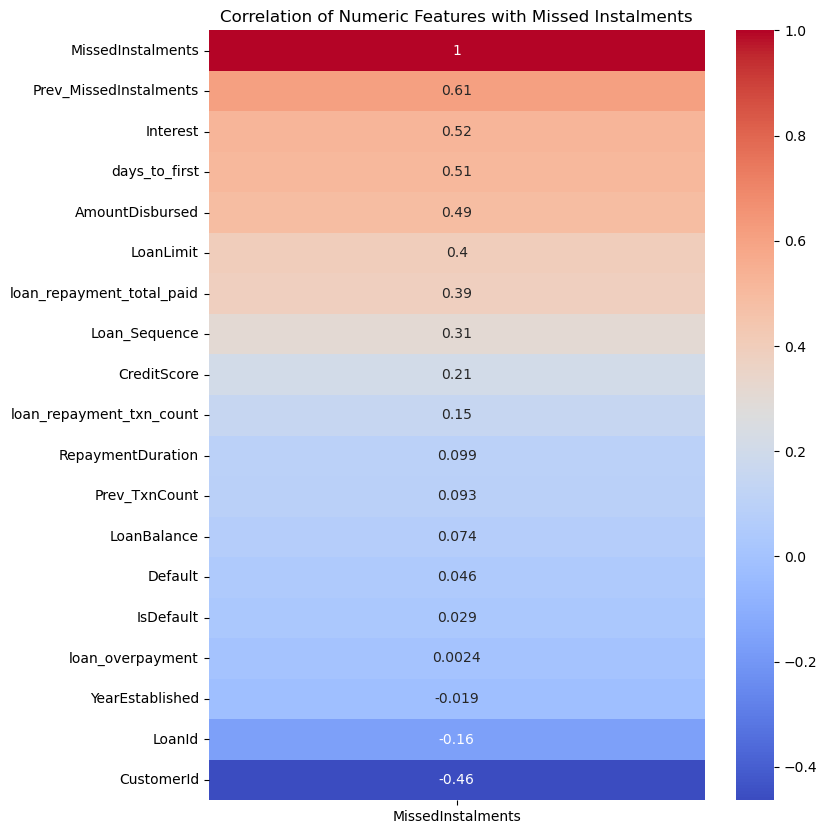

In [121]:
# Correlation With MissedInstalments (Behavioural Target)
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation with MissedInstalments
corr_with_missed = numeric_df.corr()['MissedInstalments'].sort_values(ascending=False)

# Plot heatmap
plt.figure(figsize=(8,10))
sns.heatmap(corr_with_missed.to_frame(), annot=True, cmap='coolwarm')
plt.title("Correlation of Numeric Features with Missed Instalments")
plt.show()

# Positive correlation - Feature increases missed instalments
# Example: Higher LoanBalance -> more missed instalments

# Negative correlation - Feature reduces missed instalments
# Example: Higher CreditScore -> fewer missed instalments

# Near zero - No meaningful relationship

# This helps you identify: strong predictors, weak or irrelevant features, behavioural patterns, early warning indicators

#Top predictors: Prev_MissedInstalments, Interest, days_to_first, AmountDisbursed
# Surprising correlations: loan_repayment_total_paid is positively correlated — this may mean borrowers repay partially but still miss instalments.
# Weak predictors: CreditScore shows only a mild correlation. You may want to explore whether it’s outdated or poorly calibrated.

#This correlation map helps you:
# - Select features for modelling
# - Prioritize variables for dashboard summaries
# - Identify behavioural risk signals
# - Spot features that may need transformation or segmentation


# Feature Engineering

C:\Users\kunal\AppData\Local\Temp\ipykernel_20972\802095256.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_active['DefaultRate'] = (df_not_active['MissedInstalments'] > 0).astype(int)


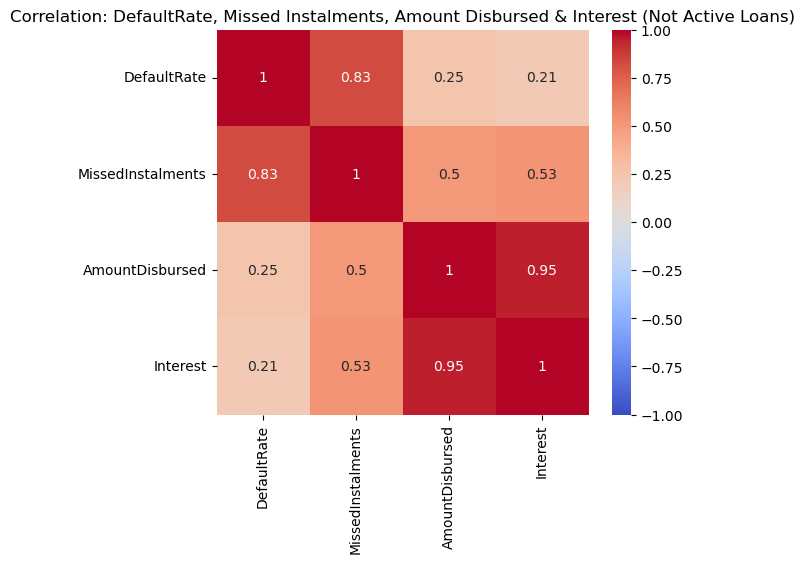

In [122]:
#Correlation on the call
cutoff = pd.to_datetime("2025-12-15")
df_not_active = df[df['ClearDate'] < cutoff]
df_not_active['DefaultRate'] = (df_not_active['MissedInstalments'] > 0).astype(int)

corr_features = df_not_active[['DefaultRate', 'MissedInstalments', 'AmountDisbursed', 'Interest']].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_features, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation: DefaultRate, Missed Instalments, Amount Disbursed & Interest (Not Active Loans)")
plt.show()

Default                      1.000000
balance_to_disbursed         0.612817
LoanBalance                  0.595684
log_LoanBalance              0.575447
balance_to_limit             0.527044
LoanId                       0.389670
CustomerId                   0.243819
days_from_last_to_clear      0.186981
interest_rate_pct            0.139951
RepaymentDuration            0.107121
loan_term_days               0.107121
MissedInstalments            0.046220
YearEstablished              0.041450
Interest                     0.033517
LoanLimit                    0.021390
log_LoanLimit                0.019166
avg_payment_amount           0.003665
AmountDisbursed              0.003134
log_AmountDisbursed          0.002772
CreditScore                 -0.005988
business_age_at_loan        -0.006796
limit_utilization           -0.023013
loan_overpayment            -0.023043
overpayment_ratio           -0.023275
Loan_Sequence               -0.044347
Prev_TxnCount               -0.048714
IsDefault   

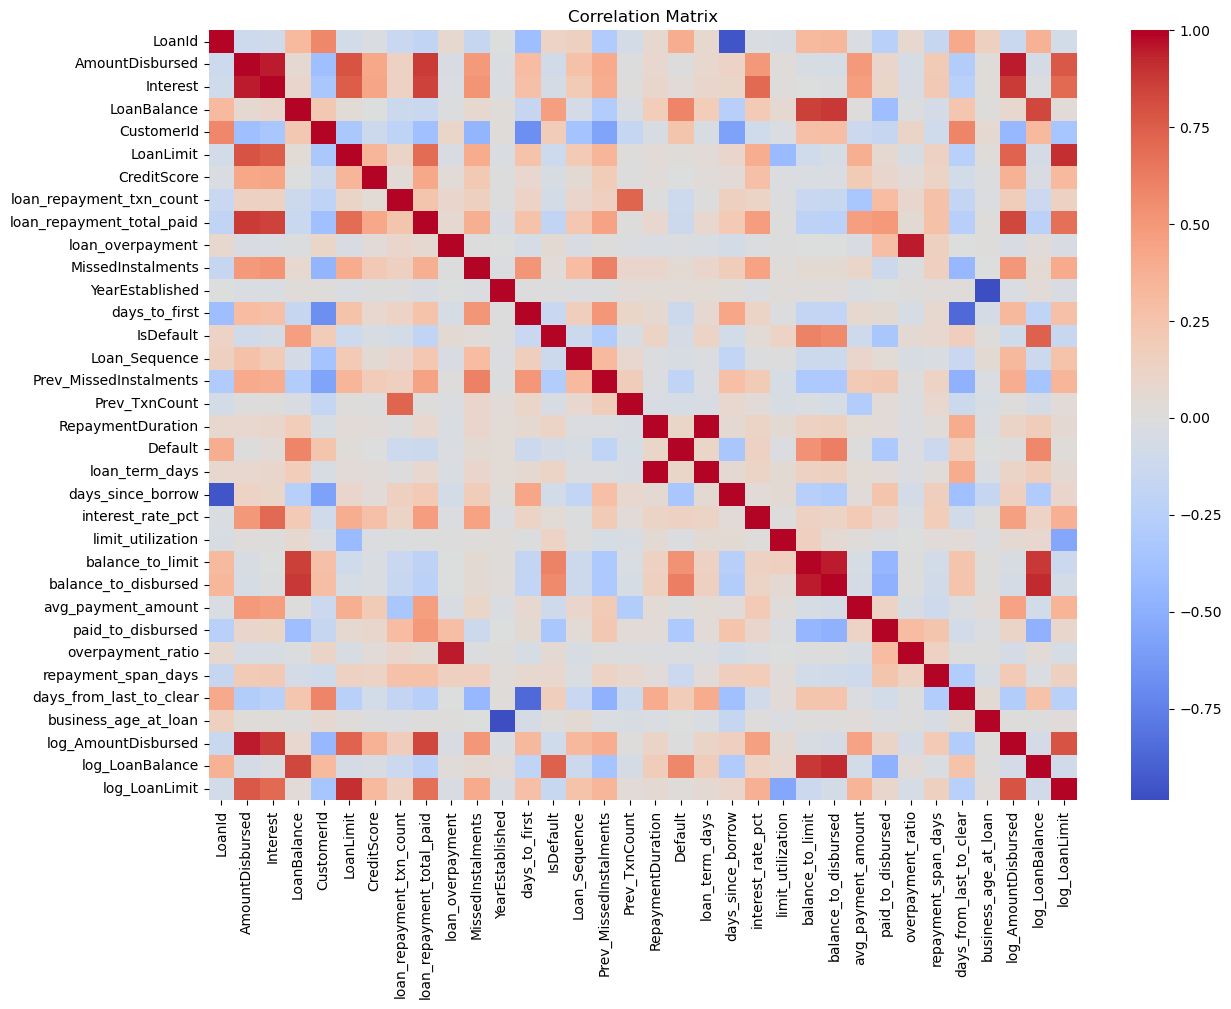

In [ ]:
# 1.1 Loan Structure Feature
# High balance_to_disbursed -> borrower hasn’t repaid -> higher default risk.
# High limit_utilization -> borrower is maxing out credit -> riskier.

# Loan term (if cleared)
df['loan_term_days'] = (df['ClearDate'] - df['BorrowDate']).dt.days

# Days since loan disbursement (try to change it to cut off date)
today = pd.Timestamp.today()
df['days_since_borrow'] = (today - df['BorrowDate']).dt.days

# Interest rate as % of principal
df['interest_rate_pct'] = df['Interest'] / df['AmountDisbursed'].replace(0, np.nan)

# Limit utilisation (similar to Amr)
df['limit_utilization'] = df['AmountDisbursed'] / df['LoanLimit'].replace(0, np.nan)

# Balance ratios
df['balance_to_limit'] = df['LoanBalance'] / df['LoanLimit'].replace(0, np.nan)
df['balance_to_disbursed'] = df['LoanBalance'] / df['AmountDisbursed'].replace(0, np.nan)


#1.2 Repayment Behaviour Feature
# paid_to_disbursed < 0.3 -> strong default signal.
# days_from_last_to_clear > 90 -> borrower likely delinquent.
# repayment_span_days shows repayment consistency.

# Average payment size
df['avg_payment_amount'] = df['loan_repayment_total_paid'] / df['loan_repayment_txn_count'].replace(0, np.nan)

# Repayment coverage ratio
df['paid_to_disbursed'] = df['loan_repayment_total_paid'] / df['AmountDisbursed'].replace(0, np.nan)

# Overpayment ratio
df['overpayment_ratio'] = df['loan_overpayment'] / df['AmountDisbursed'].replace(0, np.nan)

# Days between first and last repayment
df['repayment_span_days'] = (df['loan_repayment_last_payment'] - df['loan_repayment_first_payment']).dt.days

# Days from last payment to clear (or today - take the cut off date)
df['effective_clear_date'] = df['ClearDate'].fillna(today)
df['days_from_last_to_clear'] = (df['effective_clear_date'] - df['loan_repayment_last_payment']).dt.days
df.drop(columns=['effective_clear_date'], inplace=True)


# 1.3 Business Stability Feature
# Older businesses -> more stable -> lower default.
# Log transforms help models understand skewed money distributions.

df['business_age_at_loan'] = df['BorrowDate'].dt.year - df['YearEstablished']

# Log transforms for skewed financial variables
q

#1.4 Categorical Encoding
# Each dummy variable shows whether a borrower belongs to a segment.
# Some segments will show higher default correlation.

categorical_cols = [
    'Product', 'Branch', 'Gender', 'Industry', 'BusinessType',
    'Product_Code', 'Branch_Code'
]

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# CORRELATION MATRIX
target = 'Default'

numeric_cols = df_encoded.select_dtypes(include=[np.number]).columns
corr_matrix = df_encoded[numeric_cols].corr()

corr_with_target = corr_matrix[target].sort_values(ascending=False)
print(corr_with_target)

plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()


In [ ]:
df[[
 'loan_term_days', 'days_since_borrow', 'interest_rate_pct',
 'limit_utilization', 'balance_to_limit', 'balance_to_disbursed',
 'avg_payment_amount', 'paid_to_disbursed', 'overpayment_ratio',
 'repayment_span_days', 'days_from_last_to_clear',
 'business_age_at_loan', 'log_AmountDisbursed', 'log_LoanBalance',
 'log_LoanLimit'
]].head(10)

# all engineered columns
# loan_term_days - Actual loan duration
# days_since_borrow - Loan age
# interest_rate_pct - Pricing risk
# limit_utilization - % of credit limit used
# balance_to_limit - Remaining balance vs limit
# balance_to_disbursed - Remaining balance vs principal
# avg_payment_amount - Typical repayment size
# paid_to_disbursed - Repayment coverage
# overpayment_ratio - Extra payments
# repayment_span_days - Time between first & last payment
# days_from_last_to_clear - Time since last payment
# business_age_at_loan - Business maturity
# log_AmountDisbursed - Normalised loan size
# log_LoanBalance - Normalised balance
# log_LoanLimit - Normalised limit

,loan_term_days,days_since_borrow,interest_rate_pct,limit_utilization,balance_to_limit,balance_to_disbursed,avg_payment_amount,paid_to_disbursed,overpayment_ratio,repayment_span_days,days_from_last_to_clear,business_age_at_loan,log_AmountDisbursed,log_LoanBalance,log_LoanLimit
2576,293,682,0.275000,0.571429,0.0,0.0,980.769231,1.275000,0.0,112,-261,2,9.210440,0.0,9.770013
124,0,596,0.385000,1.000000,0.0,0.0,264.000000,0.026400,0.0,0,-468,12,9.210440,0.0,9.210440
521,3,676,0.291667,0.400000,0.0,0.0,1937.500000,1.291667,0.0,15,-565,5,8.699681,0.0,9.615872
2005,0,528,0.300000,0.632911,0.0,0.0,722.222222,1.300000,0.0,19,-450,5,8.517393,0.0,8.974745
2192,1,493,0.275000,0.877193,0.0,0.0,1275.000000,1.275000,0.0,39,-453,5,9.210440,0.0,9.341456
231,95,470,0.275000,0.500000,0.0,0.0,1286.500000,0.257300,0.0,8,-344,6,9.210440,0.0,9.903538
344,6,100,0.312500,0.500000,0.0,0.0,1233.333333,0.925000,0.0,19,-29,6,8.294300,0.0,8.987322
2338,91,479,0.300000,0.704225,0.0,0.0,590.909091,1.300000,0.0,29,-220,11,8.517393,0.0,8.867991
2575,183,264,0.300000,0.746269,0.0,0.0,343.923077,0.894200,0.0,30,31,6,8.517393,0.0,8.810012
1523,104,675,0.533333,0.454545,0.0,0.0,3285.714286,1.533333,0.0,28,-22,11,9.615872,0.0,10.404293


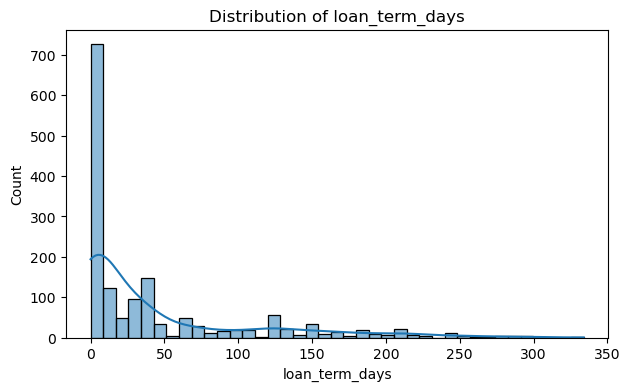

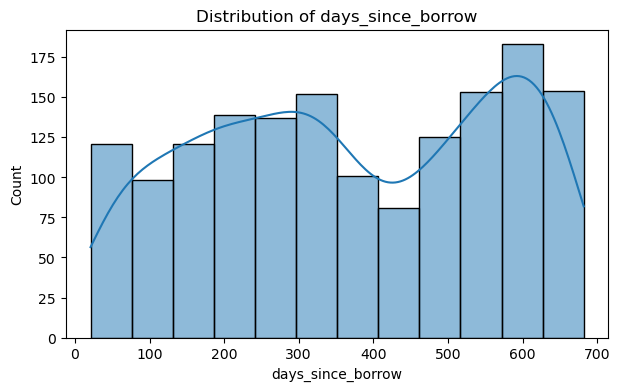

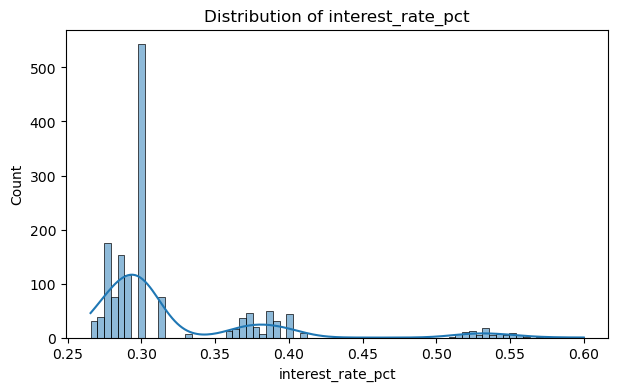

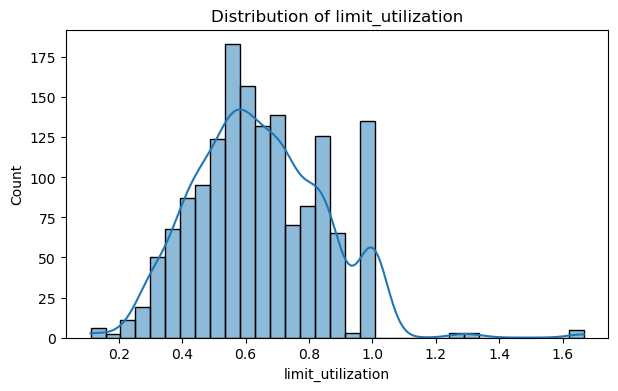

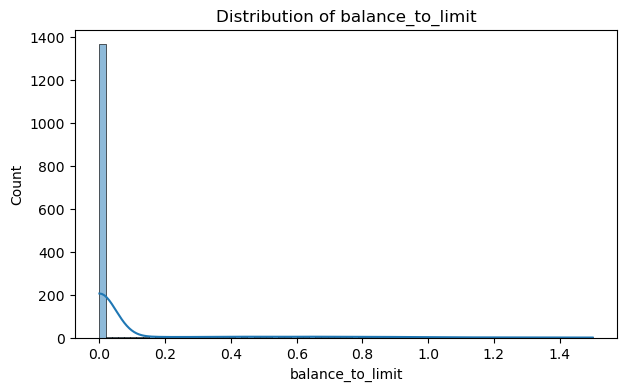

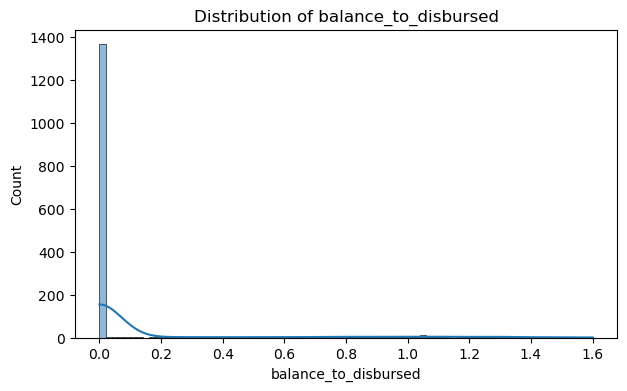

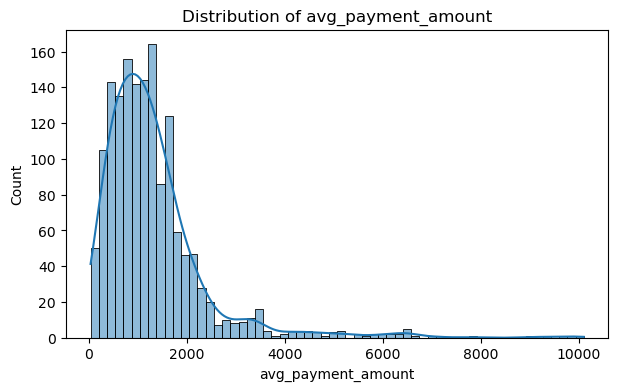

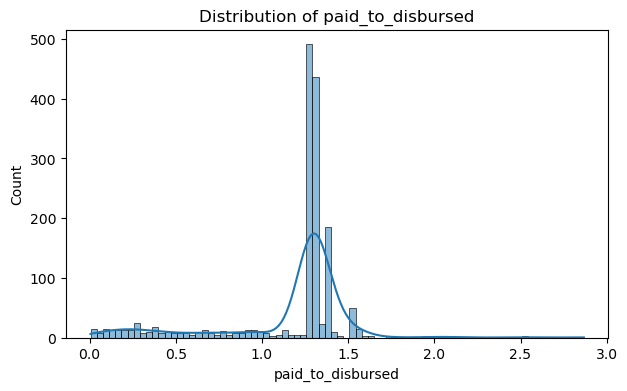

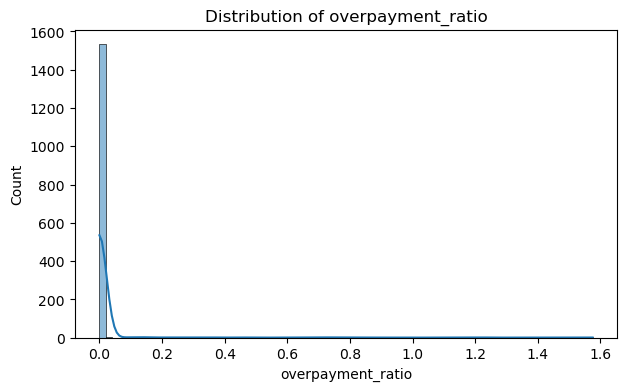

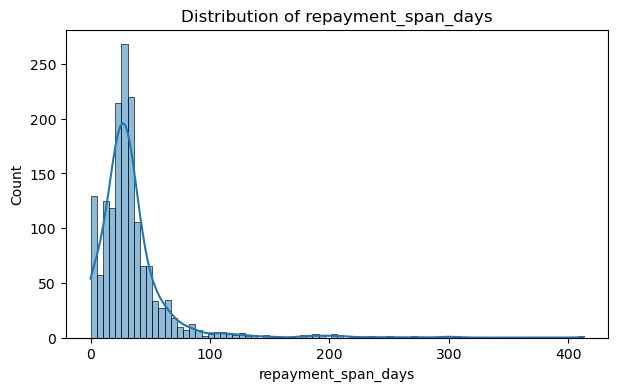

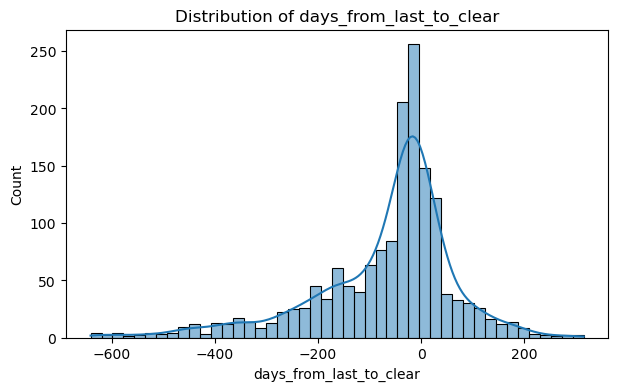

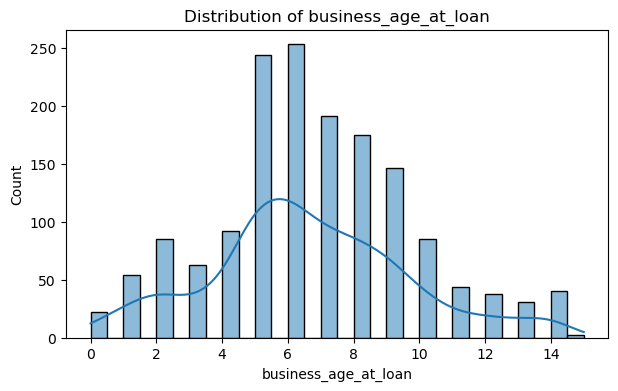

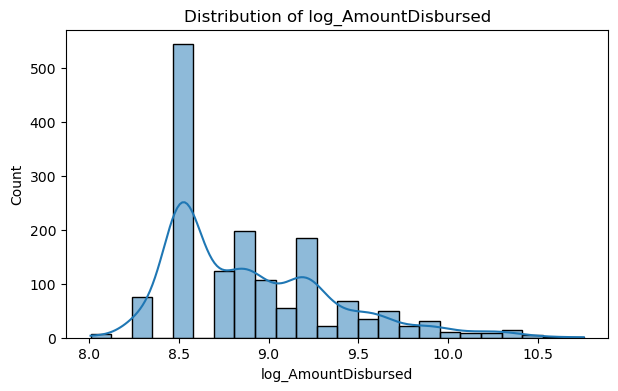

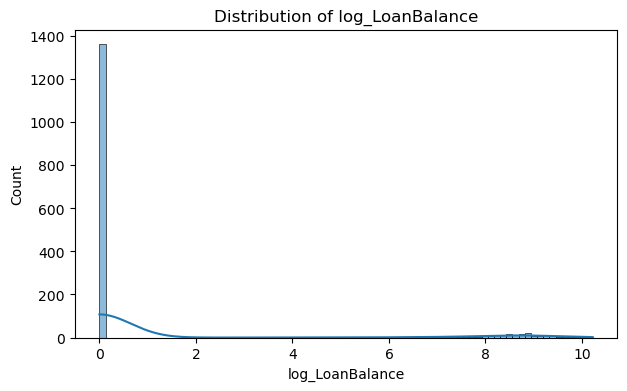

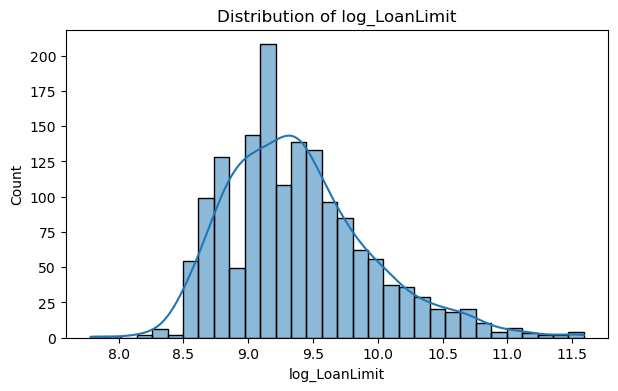

In [136]:
#EDA on the Engineer columns

engineered_cols = [
    'loan_term_days', 'days_since_borrow', 'interest_rate_pct',
    'limit_utilization', 'balance_to_limit', 'balance_to_disbursed',
    'avg_payment_amount', 'paid_to_disbursed', 'overpayment_ratio',
    'repayment_span_days', 'days_from_last_to_clear',
    'business_age_at_loan', 'log_AmountDisbursed', 'log_LoanBalance',
    'log_LoanLimit'
]

df[engineered_cols].describe().T


for col in engineered_cols:
    plt.figure(figsize=(7,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()


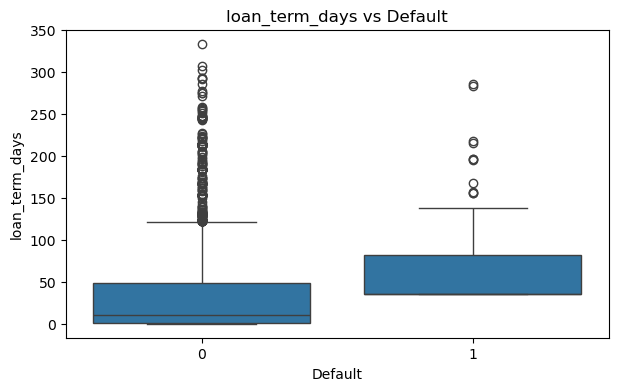

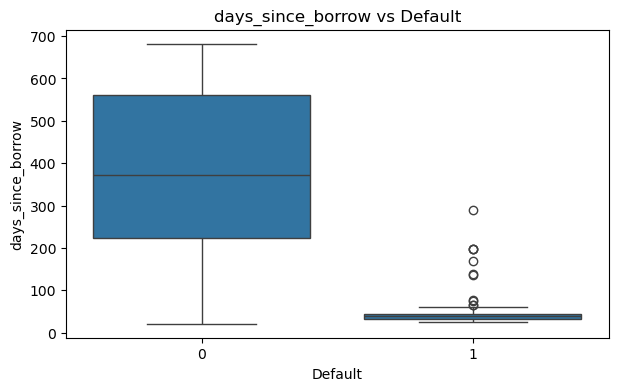

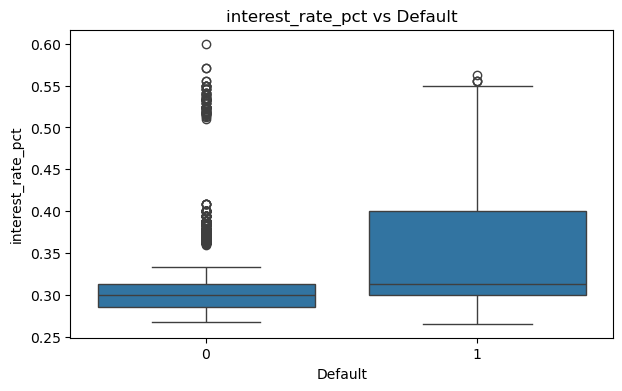

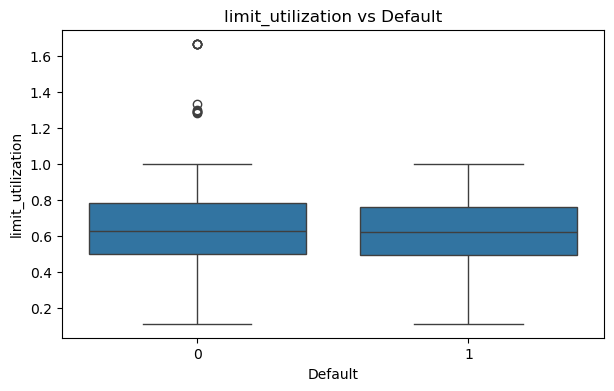

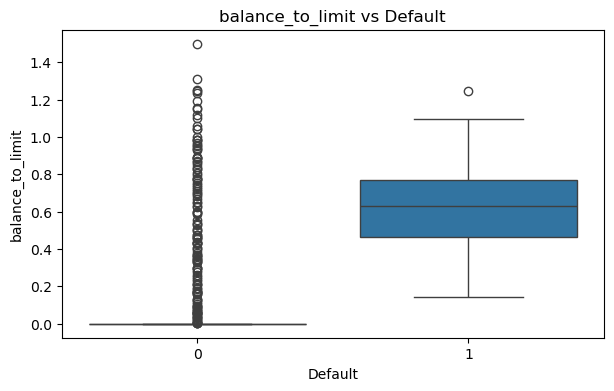

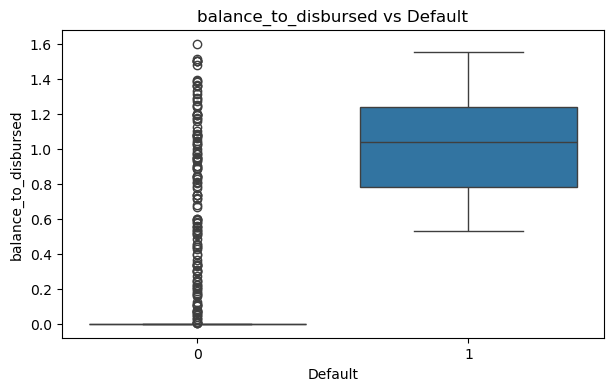

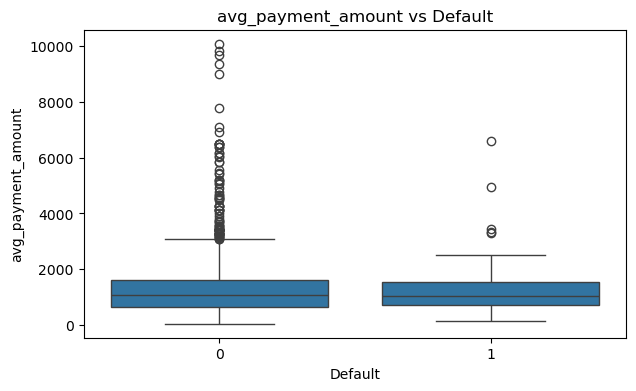

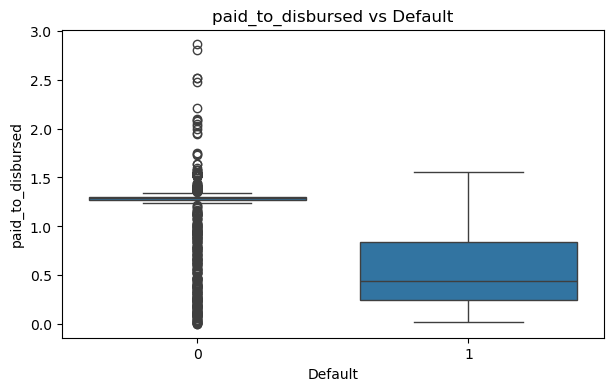

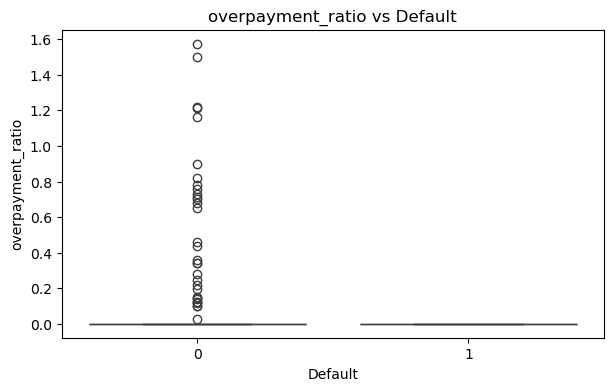

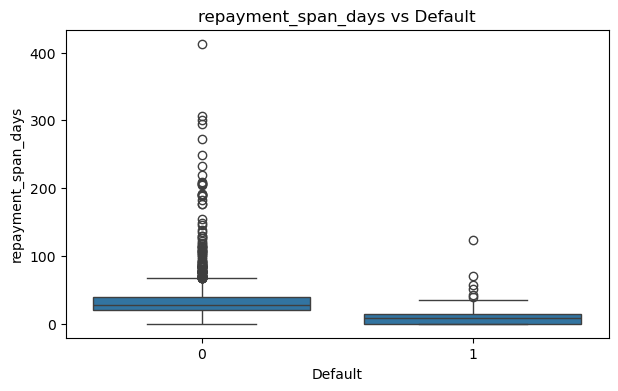

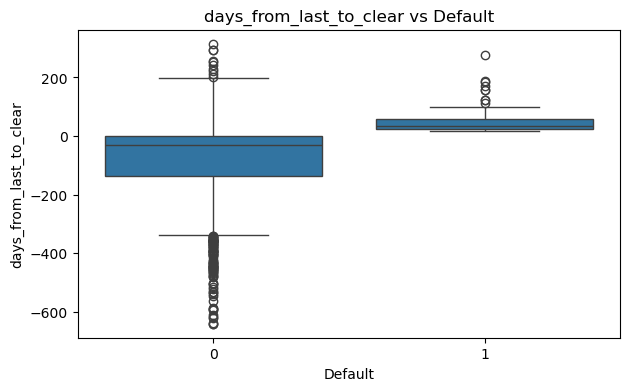

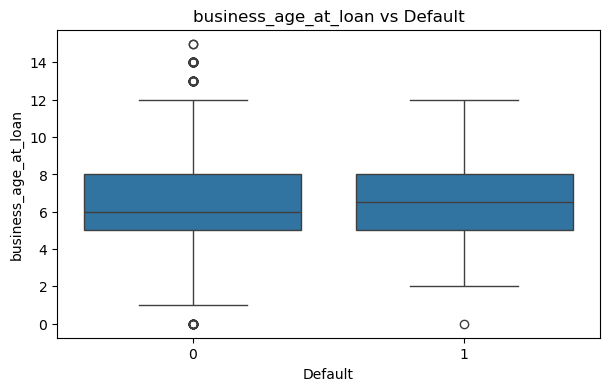

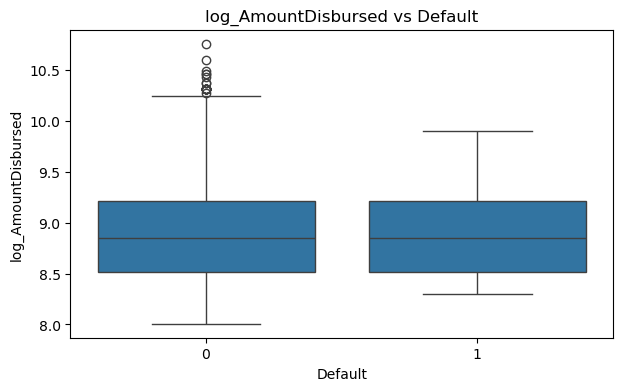

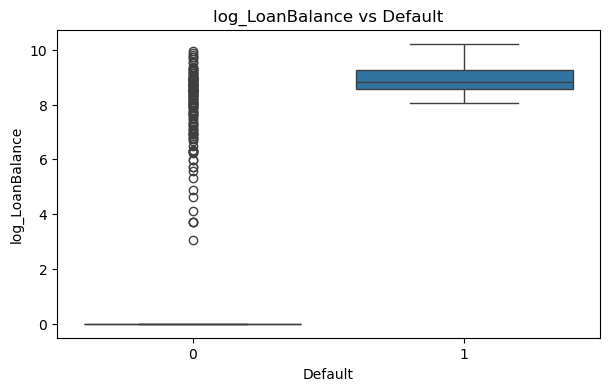

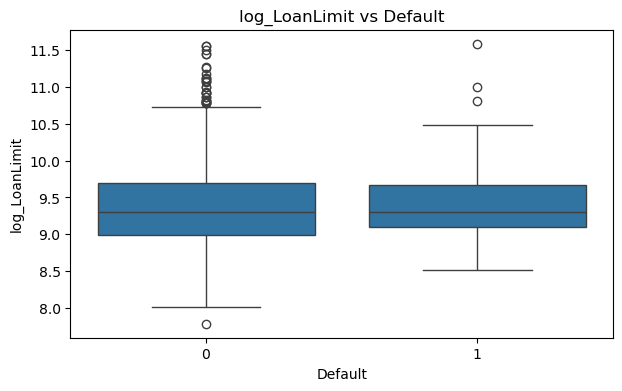

In [139]:
# Compare Defaulters vs Non‑Defaulters
for col in engineered_cols:
    plt.figure(figsize=(7,4))
    sns.boxplot(x=df['Default'], y=df[col])
    plt.title(f"{col} vs Default")
    plt.show()


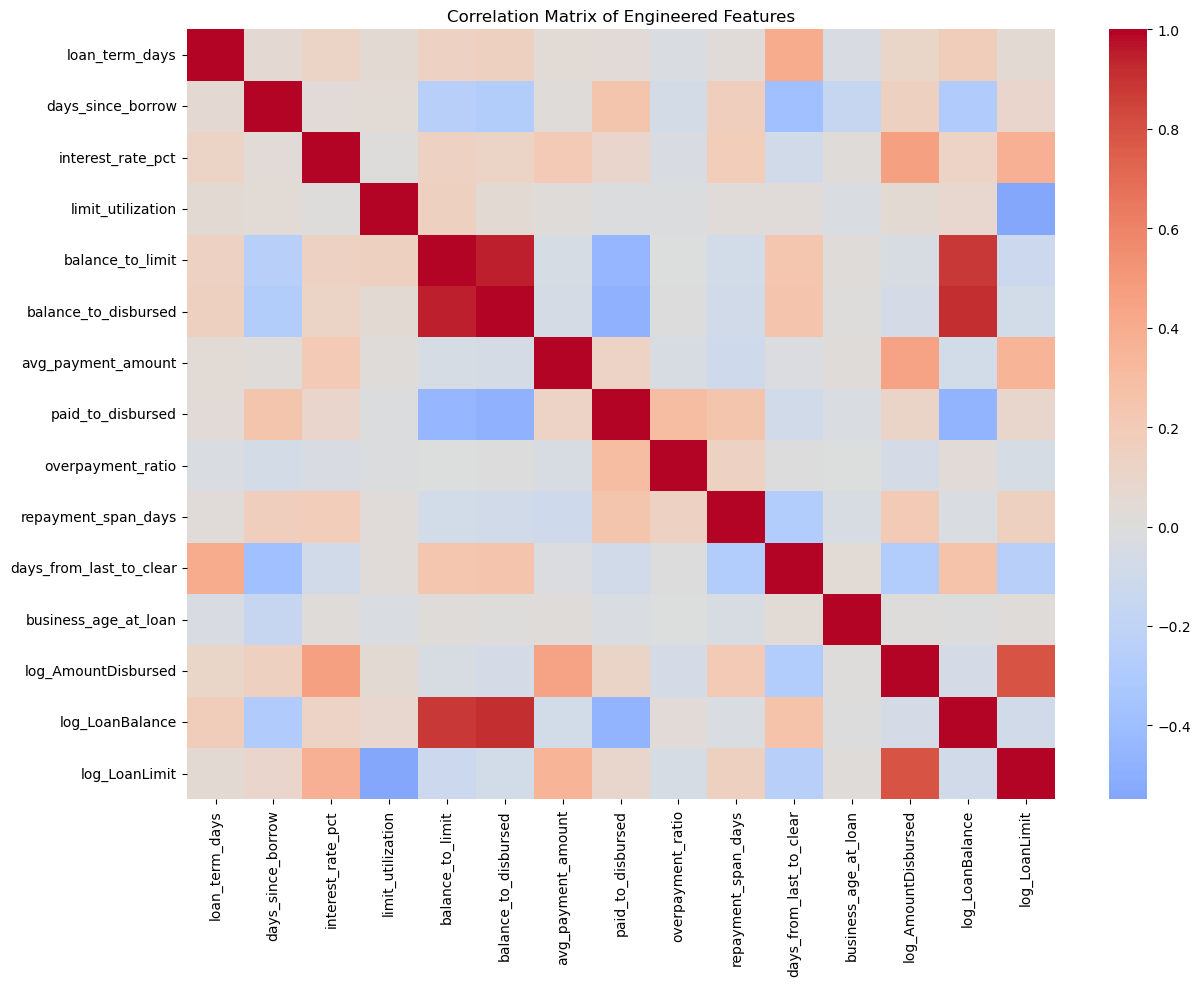

In [ ]:
# Correlation Heatmap (Engineered Features Only)

plt.figure(figsize=(14,10))
sns.heatmap(df[engineered_cols].corr(), annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Engineered Features")
plt.show()


In [148]:
# Correlation with DefaultFlag (Feature Importance Preview)
corr_target = df[engineered_cols + ['Default']].corr()['Default'].sort_values(ascending=False)
corr_target

Default                    1.000000
balance_to_disbursed       0.612817
log_LoanBalance            0.575447
balance_to_limit           0.527044
days_from_last_to_clear    0.186981
interest_rate_pct          0.139951
loan_term_days             0.107121
log_LoanLimit              0.019166
avg_payment_amount         0.003665
log_AmountDisbursed        0.002772
business_age_at_loan      -0.006796
limit_utilization         -0.023013
overpayment_ratio         -0.023275
repayment_span_days       -0.128985
paid_to_disbursed         -0.316086
days_since_borrow         -0.331877
Name: Default, dtype: float64

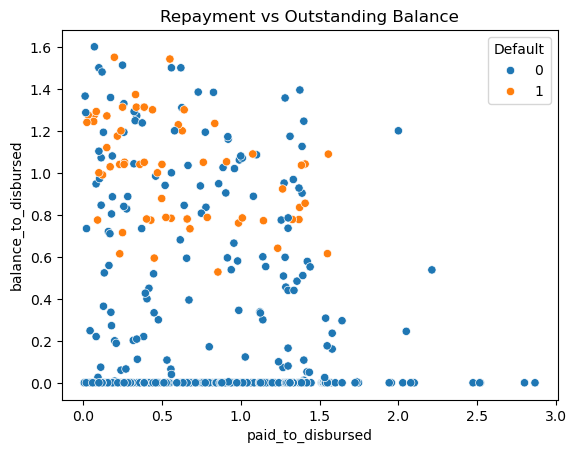

In [150]:
# Scatterplots for Behavioural Pattern

sns.scatterplot(x='paid_to_disbursed', y='balance_to_disbursed', hue='Default', data=df)
plt.title("Repayment vs Outstanding Balance")
plt.show()

In [151]:
# Trading businesses default the most
# Manufacturing defaults the least
# This is gold for product strategy.

df.groupby('Industry')['Default'].mean().sort_values(ascending=False)

Industry
business & information              0.142857
general hardware & electronics      0.058824
fashion & beauty products           0.057325
personal services                   0.054688
natural resources/environmental     0.054054
personal & professional services    0.045455
food & hospitality                  0.041170
agriculture, forestry & fishing     0.037037
wholesale & retail trade            0.027027
transportation                      0.023810
agriculture                         0.015385
automobile services                 0.000000
human health & animal services      0.000000
hospitality & tourism               0.000000
education                           0.000000
finance & insurance                 0.000000
construction & real estate          0.000000
manufacturing                       0.000000
not defined                         0.000000
real estate & housing               0.000000
Name: Default, dtype: float64

In [155]:
df.head(20)

,LoanId,AmountDisbursed,Interest,LoanBalance,BorrowDate,Product,Branch,ClearDate,CustomerId,Gender,LoanLimit,CreditScore,loan_repayment_txn_count,loan_repayment_total_paid,loan_repayment_first_payment,loan_repayment_last_payment,loan_overpayment,MissedInstalments,Industry,BusinessType,YearEstablished,days_to_first,Product_Code,Branch_Code,ScoreRange,IsDefault,LoanAmountBin,LoanRepaymentTxnCountBin,Loan_Sequence,Prev_MissedInstalments,Prev_TxnCount,RepaymentDuration,Default,loan_term_days,days_since_borrow,interest_rate_pct,limit_utilization,balance_to_limit,balance_to_disbursed,avg_payment_amount,paid_to_disbursed,overpayment_ratio,repayment_span_days,days_from_last_to_clear,business_age_at_loan,log_AmountDisbursed,log_LoanBalance,log_LoanLimit
2576,646265,10000,2750,0.0,2024-02-13,5 weeks credit ease,molo,2024-12-02,23,male,17500.0,1800,13,12750,2025-04-30,2025-08-20,0,5.0,natural resources/environmental,firewood & charcoal vendor,2022,442,1,1,2k,0,10k-15k,10-19,2,NaN,NaN,293,0,293,682,0.275000,0.571429,0.0,0.0,980.769231,1.275000,0.0,112,-261,2,9.210440,0.0,9.770013
124,720868,10000,3850,0.0,2024-05-09,7 weeks credit ease,molo,2024-05-09,23,male,10000.0,2000,1,264,2025-08-20,2025-08-20,0,7.0,food & hospitality,green grocery (fruit/vegetables),2012,468,2,1,2.5k,0,10k-15k,0-4,3,5.0,13.0,0,0,0,596,0.385000,1.000000,0.0,0.0,264.000000,0.026400,0.0,0,-468,12,9.210440,0.0,9.210440
521,650669,6000,1750,0.0,2024-02-19,5 weeks credit ease,molo,2024-02-22,90,male,15000.0,2000,4,7750,2025-08-25,2025-09-09,0,5.0,food & hospitality,green grocery (fruit/vegetables),2019,553,1,1,2.5k,0,5k-10k,0-4,2,NaN,NaN,3,0,3,676,0.291667,0.400000,0.0,0.0,1937.500000,1.291667,0.0,15,-565,5,8.699681,0.0,9.615872
2005,705587,5000,1500,0.0,2024-07-16,5 weeks credit ease,molo,2024-07-16,90,male,7900.0,2000,9,6500,2025-09-20,2025-10-09,0,5.0,fashion & beauty products,second hand clothes,2019,431,1,1,2.5k,0,5k-10k,5-9,3,5.0,4.0,0,0,0,528,0.300000,0.632911,0.0,0.0,722.222222,1.300000,0.0,19,-450,5,8.517393,0.0,8.974745
2192,720456,10000,2750,0.0,2024-08-20,5 weeks credit ease,molo,2024-08-21,90,male,11400.0,2500,10,12750,2025-10-09,2025-11-17,0,5.0,fashion & beauty products,second hand clothes,2019,415,1,1,3k,0,10k-15k,10-19,4,5.0,9.0,1,0,1,493,0.275000,0.877193,0.0,0.0,1275.000000,1.275000,0.0,39,-453,5,9.210440,0.0,9.341456
231,768510,10000,2750,0.0,2024-09-12,5 weeks credit ease,molo,2024-12-16,90,male,20000.0,2000,2,2573,2025-11-17,2025-11-25,0,5.0,food & hospitality,green grocery (fruit/vegetables),2018,431,1,1,2.5k,0,10k-15k,0-4,5,5.0,10.0,95,0,95,470,0.275000,0.500000,0.0,0.0,1286.500000,0.257300,0.0,8,-344,6,9.210440,0.0,9.903538
344,892199,4000,1250,0.0,2025-09-17,5 weeks credit ease,molo,2025-09-23,156,female,8000.0,2000,3,3700,2025-10-03,2025-10-22,0,5.0,hospitality & tourism,entertainment/party & events planning,2019,16,1,1,2.5k,0,0-5k,0-4,2,NaN,NaN,6,0,6,100,0.312500,0.500000,0.0,0.0,1233.333333,0.925000,0.0,19,-29,6,8.294300,0.0,8.987322
2338,657768,5000,1500,0.0,2024-09-03,5 weeks credit ease,molo,2024-12-03,180,male,7100.0,2500,11,6500,2025-06-12,2025-07-11,0,5.0,agriculture,green grocery (fruit/vegetables),2013,282,1,1,3k,0,5k-10k,10-19,2,NaN,NaN,91,0,91,479,0.300000,0.704225,0.0,0.0,590.909091,1.300000,0.0,29,-220,11,8.517393,0.0,8.867991
2575,836666,5000,1500,0.0,2025-04-06,5 weeks credit ease,molo,2025-10-06,180,female,6700.0,2000,13,4471,2025-08-06,2025-09-05,0,5.0,food & hospitality,green grocery (fruit/vegetables),2019,122,1,1,2.5k,0,5k-10k,10-19,3,5.0,11.0,183,0,183,264,0.300000,0.746269,0.0,0.0,343.923077,0.894200,0.0,30,31,6,8.517393,0.0,8.810012
1523,641972,15000,8000,0.0,2024-02-20,10 weeks credit ease,molo,2024-06-03,295,female,33000.0,7000,7,23000,2024-05-28,2024-06-25,0,10.0,agriculture,farming-animal products,2013,98,0,1,7.5k,0,15k-20k,5-9,2,NaN,NaN,104,0,104,675,0.533333,0.454545,0.0,0.0,3285.714286,1.533333,0.0,28,-22,11,9.615872,0.0,10.404293


In [154]:
# ML model
# 1. Drop datetime columns
datetime_cols = [
    'BorrowDate',
    'ClearDate',
    'loan_repayment_first_payment',
    'loan_repayment_last_payment'
]

df_encoded = df_encoded.drop(columns=datetime_cols, errors='ignore')

# 2. Define X and y
target = 'Default'
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

# 3. Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

# 4. Class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

weights = {0: class_weights[0], 1: class_weights[1]}

# 5. Logistic Regression
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    class_weight=weights,
    max_iter=500,
    solver='lbfgs'
)

log_reg.fit(X_train, y_train)

ValueError: Cannot cast object dtype to float64

In [ ]:
# 1. Drop datetime columns
datetime_cols = [
    'BorrowDate',
    'ClearDate',
    'loan_repayment_first_payment',
    'loan_repayment_last_payment'
]

df_encoded = df_encoded.drop(columns=datetime_cols, errors='ignore')

# 2. Drop columns with 'k' or 'M' formatted values
def has_k_or_m_values(series):
    if series.dtype != 'object':
        return False
    s = series.astype(str).str.strip().str.lower()
    return s.str.contains(r'^\d+(\.\d+)?\s*[km]$', regex=True).any()

cols_with_km = [col for col in df_encoded.columns if has_k_or_m_values(df_encoded[col])]
df_encoded = df_encoded.drop(columns=cols_with_km, errors='ignore')

# 3. Define target and numeric features
target = 'Default'
X = df_encoded.drop(columns=[target])
y = df_encoded[target]
X = X.select_dtypes(include='number')

# 4. Impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# 5. Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 6. Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

# 7. Compute class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
weights = dict(zip(np.unique(y_train), class_weights))

# 8. Train Logistic Regression
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    class_weight=weights,
    max_iter=2000,  # increased for convergence
    solver='lbfgs'
)

log_reg.fit(X_train, y_train)

#Interpretation
# penalty - Adds a “penalty” to large coefficients to prevent overfitting. Think of it as a safety brake.
# dual - Uses the standard way to solve the math behind the model. You don’t need the “dual” shortcut.
# tol - The model stops training when changes become very tiny, this sets how tiny is “tiny enough.”
# C - Controls how much freedom the model has. Lower values = stricter rules. Higher = more flexible
# fit_intercept - Adds a baseline prediction (intercept) to the model, like starting from a default guess.
# class_weight - Tells the model to care much more about predicting defaults (class 1).
# solver - The algorithm used to train the model, good for small to medium datasets.
# max_iter - Maximum number of training steps. You increased this to help the model finish learning
# multi_class - You’re doing binary classification (default vs non-default), so this isn’t used.
# verbose - No training logs printed, keeps the output clean.
# warm_start - Starts fresh every time, doesn’t reuse previous training.
# n_jobs - Uses one CPU core, no parallel processing.
# l1_ration - Not used unless you switch to a different penalty type (like elasticnet).

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,"{np.int64(0): np.float64(0.5213333333333333), np.int64(1): np.float64(12.21875)}"
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


Accuracy: 0.9897959183673469
Precision: 0.8
Recall: 1.0
F1 Score: 0.8888888888888888
ROC-AUC: 0.999501329787234

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       376
           1       0.80      1.00      0.89        16

    accuracy                           0.99       392
   macro avg       0.90      0.99      0.94       392
weighted avg       0.99      0.99      0.99       392

Confusion Matrix:
 [[372   4]
 [  0  16]]


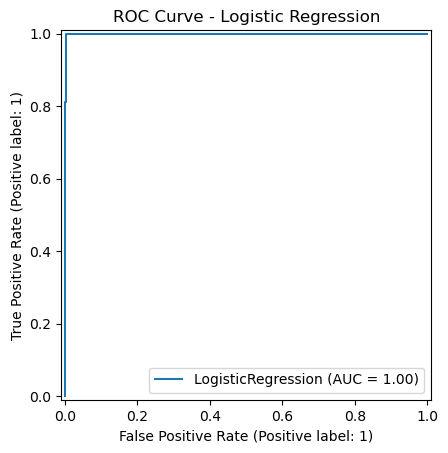

In [ ]:
# Evaluate Model Performance

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay

# Predictions
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# ROC Curve
RocCurveDisplay.from_estimator(log_reg, X_test, y_test)
plt.title("ROC Curve - Logistic Regression")
plt.show()

# Highly accurate
# Perfect at catching defaulters
# Very few false alarms
# Excellent separation ability (AUC)


In [ ]:
# Interpret Logistic Regression Coefficient

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_reg.coef_[0]
})

coef_df['Impact'] = np.where(coef_df['Coefficient'] > 0, 'Increases Default Risk', 'Decreases Default Risk')
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

print(coef_df)

# Positive coefficient -> pushes prediction toward default
# Negative coefficient -> pushes prediction toward non‑default
# Larger magnitude = stronger influence
# This is extremely useful for business insights and dashboards.

# High balances, high interest, and high utilization -> increase default risk
# Higher limits, more repayments, and older loans -> reduce default risk




                      Feature  Coefficient                  Impact
31            log_LoanBalance     2.099293  Increases Default Risk
0                      LoanId     1.026391  Increases Default Risk
4                  CustomerId     0.526621  Increases Default Risk
23       balance_to_disbursed     0.481155  Increases Default Risk
14              Loan_Sequence     0.417583  Increases Default Risk
3                 LoanBalance     0.386332  Increases Default Risk
20          interest_rate_pct     0.368589  Increases Default Risk
6                 CreditScore     0.260238  Increases Default Risk
11            YearEstablished     0.252962  Increases Default Risk
28    days_from_last_to_clear     0.251683  Increases Default Risk
18             loan_term_days     0.210295  Increases Default Risk
17          RepaymentDuration     0.210295  Increases Default Risk
15     Prev_MissedInstalments     0.157939  Increases Default Risk
22           balance_to_limit     0.143770  Increases Default 

In [ ]:
# KNN Model Training + Evaluation

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 1. Train KNN
knn = KNeighborsClassifier(
    n_neighbors=5,      # default, can tune later
    weights='distance', # better for imbalanced data
    metric='minkowski'  # standard Euclidean distance
)

knn.fit(X_train, y_train)

# 2. Predictions
knn_pred = knn.predict(X_test)
knn_prob = knn.predict_proba(X_test)[:, 1]

# 3. Evaluation
print("KNN Accuracy:", accuracy_score(y_test, knn_pred))
print("KNN Precision:", precision_score(y_test, knn_pred))
print("KNN Recall:", recall_score(y_test, knn_pred))
print("KNN F1 Score:", f1_score(y_test, knn_pred))
print("KNN ROC-AUC:", roc_auc_score(y_test, knn_prob))

# KNN model is excellent at identifying defaulters (recall = 1.0).
# It’s also very accurate overall (accuracy = 99.2%).
# The F1 score of 0.91 means it balances precision and recall well.
# The ROC-AUC of 0.995 is extremely strong — almost perfect separation.


c:\Users\kunal\AppData\Local\spyder-6\envs\spyder-runtime\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


KNN Accuracy: 0.9923469387755102
KNN Precision: 0.8421052631578947
KNN Recall: 1.0
KNN F1 Score: 0.9142857142857143
KNN ROC-AUC: 0.9950132978723405
